In [5]:
!pip install -q rhino3dm shapely trimesh matplotlib pyvista


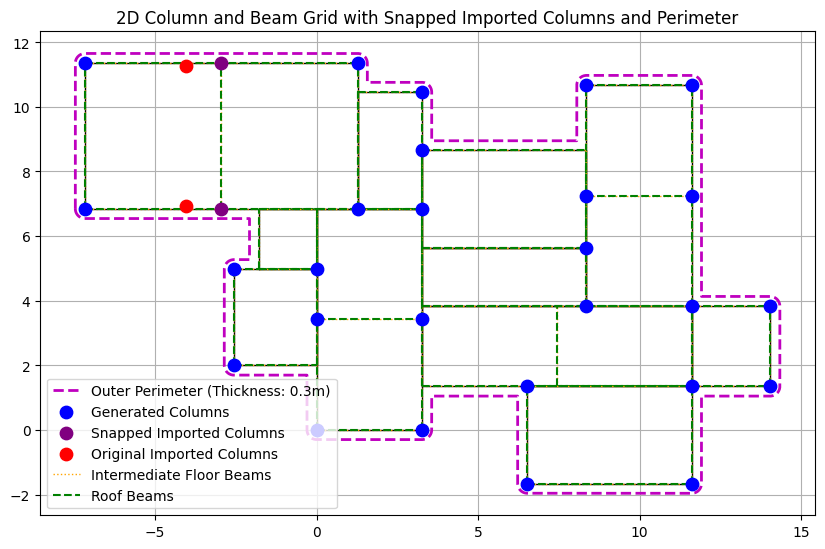

Widget(value='<iframe src="http://localhost:52103/index.html?ui=P_0x22063ebf230_0&reconnect=auto" class="pyvis…

In [1]:
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
# Note: Using the remembered path from your previous interactions.
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0 # Global maximum Z for the entire building footprint

wall_breps = []

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Min.Y] # Ensure polygon is closed for Shapely
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        wall_breps.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z) # Update global max_z

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# --- Section for perimeter line and wall thickness ---
while True:
    try:
        wall_thickness = float(input("Enter desired wall thickness for the perimeter (e.g., 0.3): "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for wall thickness.")

# Combine all building polygons into a single MultiPolygon
combined_building_polygon = MultiPolygon(building_volumes)

# Get the exterior boundary of the combined building and offset it
try:
    exterior_perimeter = combined_building_polygon.buffer(wall_thickness, join_style=1) # join_style=1 for mitered joints
except Exception as e:
    print(f"Could not buffer the building outline. Error: {e}")
    exterior_perimeter = None

# If the buffer operation results in a MultiPolygon, get the largest component
if exterior_perimeter and exterior_perimeter.geom_type == 'MultiPolygon':
    exterior_perimeter = max(exterior_perimeter.geoms, key=lambda p: p.area)

perimeter_line_coords = []
if exterior_perimeter:
    if exterior_perimeter.geom_type == 'Polygon':
        # Extract the exterior ring coordinates
        perimeter_line_coords = list(exterior_perimeter.exterior.coords)
    elif exterior_perimeter.geom_type == 'MultiPolygon':
        # For MultiPolygon, take the exterior of the largest polygon component
        perimeter_line_coords = list(exterior_perimeter.geoms[0].exterior.coords)
    else:
        print("Warning: The buffered perimeter is not a Polygon or MultiPolygon. Cannot extract line coordinates.")

# --- End perimeter section ---

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Plot the new perimeter line
if perimeter_line_coords:
    px_perimeter, py_perimeter = zip(*perimeter_line_coords)
    ax.plot(px_perimeter, py_perimeter, 'm--', linewidth=2, label=f'Outer Perimeter (Thickness: {wall_thickness}m)')

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor_num in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                            label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns and Perimeter")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data):
    pt = np.array([x, y])
    closest_wall = None
    closest_dist = float('inf')

    for wall in wall_data:
        poly = wall['polygon']
        dist = poly.exterior.distance(Point(x, y))
        if dist < closest_dist:
            closest_dist = dist
            closest_wall = wall

    if closest_wall:
        return closest_wall['bbox'].Max.Z
    else:
        return max_z  # fallback to global max_z

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Define sizes for structural elements (now dimensions for rectangular prisms)
column_width = 0.3 # Example: 30cm x 30cm columns
column_depth = 0.3

# Updated beam and slab thicknesses
beam_width = 0.2 - 0.05 # 0.05 thinner
beam_depth = 0.4 - 0.05 # 0.05 thinner

slab_thickness = 0.15 + 0.05 # 0.05 thicker

# A small buffer to extend the slabs to cover the columns
# This should be at least half the column's dimension + a small tolerance
slab_extension_buffer = max(column_width, column_depth) / 2 + 0.01 + 0.005 # Added extra 0.005

# Columns as rectangular prisms
for x, y in all_base_columns:
    wall_height = get_wall_height(x, y, wall_breps)
    # Calculate min/max for the column's bounding box
    col_min_x = x - column_width / 2
    col_max_x = x + column_width / 2
    col_min_y = y - column_depth / 2
    col_max_y = y + column_depth / 2
    col_min_z = 0 # Columns start from ground
    col_max_z = wall_height # Columns go up to the building's height

    column_box = pv.Box([col_min_x, col_max_x, col_min_y, col_max_y, col_min_z, col_max_z])
    plotter.add_mesh(column_box, color='blue', smooth_shading=True)

# Beams as rectangular prisms
for (x1, y1), (x2, y2) in beams:
    h1 = get_wall_height(x1, y1, wall_breps)
    h2 = get_wall_height(x2, y2, wall_breps)
    floor_height_for_beams_segment = min(h1, h2)

    for floor_num in range(1, num_floors + 1):
        # Calculate the intended Z-level for the TOP surface of the slab this beam supports
        # This is (floor_num / num_floors) * max_z to get the ratio of total height for this floor
        # For the roof, this will naturally be max_z
        intended_slab_top_z_for_beam = (floor_num / num_floors) * floor_height_for_beams_segment

        # The top of the beam should align with the bottom of the slab
        beam_max_z = intended_slab_top_z_for_beam - slab_thickness
        beam_min_z = beam_max_z - beam_depth

        # Ensure beam_min_z is not negative (below ground)
        if beam_min_z < 0:
            beam_min_z = 0
            beam_max_z = beam_depth # Adjust max_z to maintain depth from ground

        # Skip beams if they (or their tops) would exceed the actual height of the wall segment
        if beam_max_z > (floor_height_for_beams_segment + 1e-6): # Compare against the specific segment height
            continue

        # Determine beam orientation (X or Y)
        if abs(x1 - x2) > abs(y1 - y2): # X-oriented beam
            beam_min_x = min(x1, x2)
            beam_max_x = max(x1, x2)
            beam_center_y = (y1 + y2) / 2
            beam_min_y = beam_center_y - beam_width / 2
            beam_max_y = beam_center_y + beam_width / 2
        else: # Y-oriented beam
            beam_min_y = min(y1, y2)
            beam_max_y = max(y1, y2)
            beam_center_x = (x1 + x2) / 2
            beam_min_x = beam_center_x - beam_width / 2
            beam_max_x = beam_center_x + beam_width / 2

        beam_box = pv.Box([beam_min_x, beam_max_x, beam_min_y, beam_max_y, beam_min_z, beam_max_z])

        color = 'green' if floor_num == num_floors else 'orange'
        plotter.add_mesh(beam_box, color=color, smooth_shading=True)

# Add slabs - REVISED SECTION
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z

    if num_floors <= 0:
        continue # No floors, no slabs

    # Apply a small buffer to the room polygon to extend the slab
    extended_room_poly = room_poly.buffer(slab_extension_buffer)

    # Calculate height of each story *for this room's total height*
    # This is the actual height of one story for this specific room geometry
    story_height = room_specific_max_z / num_floors

    for i in range(1, num_floors + 1): # loop for each floor, 1 to num_floors
        # Calculate the intended Z-level for the TOP surface of the current slab
        intended_slab_top_z = i * story_height
        
        # The base of the slab is its intended top surface Z minus its thickness
        slab_base_z = intended_slab_top_z - slab_thickness

        # Ensure slab_base_z isn't below 0 (ground level)
        if slab_base_z < 0:
            slab_base_z = 0
            # If the base starts at 0, the thickness should be adjusted to reach the intended top Z
            current_slab_thickness_for_this_level = intended_slab_top_z
        else:
            current_slab_thickness_for_this_level = slab_thickness
        
        # Final check to ensure the slab doesn't extend beyond the room's max height
        # This is especially important for the top floor to not exceed the actual building height
        if (slab_base_z + current_slab_thickness_for_this_level) > (room_specific_max_z + 1e-6):
            current_slab_thickness_for_this_level = max(0, room_specific_max_z - slab_base_z)
            if current_slab_thickness_for_this_level < 1e-6:
                continue # Skip drawing if thickness is negligible

        # Convert 2D shapely polygon coordinates to 3D points (X, Y, Z=0 for base plane) for PyVista
        points_3d_for_slab_base = []
        # Use the extended_room_poly for slab generation
        poly_coords = list(extended_room_poly.exterior.coords)
        if poly_coords[0] != poly_coords[-1]:
            poly_coords.append(poly_coords[0]) # Close the loop
            
        for x, y in poly_coords:
            points_3d_for_slab_base.append([x, y, 0.0]) # Add a Z-coordinate (0 for the base plane)
        
        points_3d_for_slab_base = np.array(points_3d_for_slab_base)

        if len(points_3d_for_slab_base) < 3: # Need at least 3 points for a polygon
            continue

        slab_base_mesh = pv.PolyData(points_3d_for_slab_base) # Pass the (N,3) array
        
        # Triangulate the 2D base polygon for extrusion
        try:
            triangulated_faces = slab_base_mesh.delaunay_2d().faces
            if triangulated_faces is None or len(triangulated_faces) == 0:
                print(f"Skipping slab due to empty triangulation for polygon {room_poly.bounds}")
                continue
            slab_base_mesh = pv.PolyData(points_3d_for_slab_base, faces=triangulated_faces) # Recreate with faces
        except Exception as e:
            print(f"Delaunay triangulation failed for a slab base ({room_poly.bounds}): {e}. Skipping slab.")
            continue

        # Extrude the triangulated base to create the 3D slab
        slab_mesh = slab_base_mesh.extrude(vector=(0, 0, current_slab_thickness_for_this_level), capping=True)
        slab_mesh = slab_mesh.translate((0, 0, slab_base_z)) # Move the slab to its correct Z level
        
        plotter.add_mesh(slab_mesh, color='sienna', opacity=0.8, smooth_shading=True)

# Add the perimeter line in 3D (at base level)
if perimeter_line_coords:
    # Convert 2D coordinates to 3D at Z=0 for the base perimeter
    perimeter_3d_points = [[x, y, 0] for x, y in perimeter_line_coords]
    
    # Create a PolyData object for the line segments
    lines = []
    for i in range(len(perimeter_3d_points) - 1):
        lines.extend([2, i, i + 1])
    # Close the loop (connect last point to first)
    if len(perimeter_3d_points) > 1:
        lines.extend([2, len(perimeter_3d_points) - 1, 0])

    perimeter_polydata = pv.PolyData(perimeter_3d_points, lines=lines)
    plotter.add_mesh(perimeter_polydata, color='magenta', line_width=5, render_lines_as_tubes=True, label="Outer Perimeter Line")

# Actual Brep-based walls visualization (semi-transparent)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show the 3D plot
plotter.show_grid()
plotter.show()

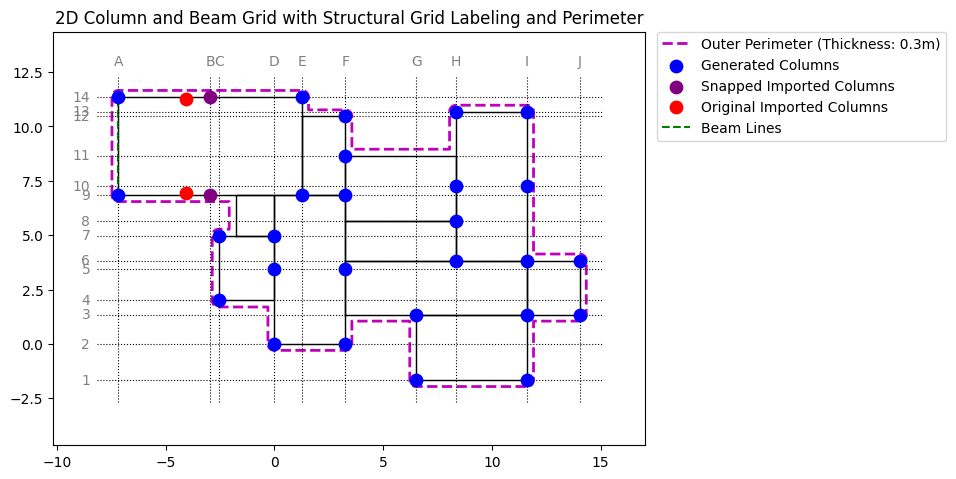

Widget(value='<iframe src="http://localhost:59281/index.html?ui=P_0x11f50d82c10_14&reconnect=auto" class="pyvi…

In [15]:
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
import matplotlib.pyplot as plt
import os
import pyvista as pv

# File path
# Note: Using the remembered path from your previous interactions.
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0 # Global maximum Z for the entire building footprint

wall_breps = []

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Min.Y] # Ensure polygon is closed for Shapely
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        wall_breps.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z) # Update global max_z

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2 for ground + 1 middle + roof): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# --- Section for perimeter line and wall thickness ---
while True:
    try:
        wall_thickness = float(input("Enter desired wall thickness for the perimeter (e.g., 0.3): "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for wall thickness.")

# Combine all building polygons into a single MultiPolygon
combined_building_polygon = MultiPolygon(building_volumes)

# Get the exterior boundary of the combined building and offset it
try:
    exterior_perimeter = combined_building_polygon.buffer(wall_thickness, join_style=1) # join_style=1 for mitered joints
except Exception as e:
    print(f"Could not buffer the building outline. Error: {e}")
    exterior_perimeter = None

# If the buffer operation results in a MultiPolygon, get the largest component
if exterior_perimeter and exterior_perimeter.geom_type == 'MultiPolygon':
    exterior_perimeter = max(exterior_perimeter.geoms, key=lambda p: p.area)

perimeter_line_coords = []
if exterior_perimeter:
    if exterior_perimeter.geom_type == 'Polygon':
        # Extract the exterior ring coordinates
        perimeter_line_coords = list(exterior_perimeter.exterior.coords)
    elif exterior_perimeter.geom_type == 'MultiPolygon':
        # For MultiPolygon, take the exterior of the largest polygon component
        perimeter_line_coords = list(exterior_perimeter.geoms[0].exterior.coords)
    else:
        print("Warning: The buffered perimeter is not a Polygon or MultiPolygon. Cannot extract line coordinates.")

# --- End perimeter section ---

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# --- COLUMN GRID NUMBERING LOGIC ---
# Get unique X and Y coordinates from all generated/snapped columns for grid lines
grid_xs = sorted(list(set([col[0] for col in all_base_columns])))
grid_ys = sorted(list(set([col[1] for col in all_base_columns])))

# Create mapping for X-coordinates to letters (A, B, C...)
x_grid_labels = {x: chr(65 + i) for i, x in enumerate(grid_xs)}
# Create mapping for Y-coordinates to numbers (1, 2, 3...)
y_grid_labels = {y: i + 1 for i, y in enumerate(grid_ys)}

# Determine the actual min/max X/Y of the columns for drawing grid lines
col_min_x_extent = min(col[0] for col in all_base_columns) if all_base_columns else 0
col_max_x_extent = max(col[0] for col in all_base_columns) if all_base_columns else 0
col_min_y_extent = min(col[1] for col in all_base_columns) if all_base_columns else 0
col_max_y_extent = max(col[1] for col in all_base_columns) if all_base_columns else 0

# Add a small buffer to the column extents for drawing grid lines
grid_extent_buffer = 1.0 # Adjust as needed for visual spacing
col_min_x_extent -= grid_extent_buffer
col_max_x_extent += grid_extent_buffer
col_min_y_extent -= grid_extent_buffer
col_max_y_extent += grid_extent_buffer

# Determine overall plot limits (consider building outline and grid labels)
min_x_plot = min(col_min_x_extent, min([coord[0] for coord in perimeter_line_coords])) - 2 if perimeter_line_coords else col_min_x_extent - 2
max_x_plot = max(col_max_x_extent, max([coord[0] for coord in perimeter_line_coords])) + 2 if perimeter_line_coords else col_max_x_extent + 2
min_y_plot = min(col_min_y_extent, min([coord[1] for coord in perimeter_line_coords])) - 2 if perimeter_line_coords else col_min_y_extent - 2
max_y_plot = max(col_max_y_extent, max([coord[1] for coord in perimeter_line_coords])) + 2 if perimeter_line_coords else col_max_y_extent + 2


# 2D Visualization
fig, ax = plt.subplots(figsize=(12, 10)) # Increased figure width for legend

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Plot the new perimeter line
if perimeter_line_coords:
    px_perimeter, py_perimeter = zip(*perimeter_line_coords)
    ax.plot(px_perimeter, py_perimeter, 'm--', linewidth=2, label=f'Outer Perimeter (Thickness: {wall_thickness}m)')

# Plot all columns
gx, gy = zip(*columns)
ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

# Only draw one label for beam lines in 2D
if beams:
    x1, y1 = beams[0][0]
    x2, y2 = beams[0][1]
    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5, label='Beam Lines')

# Draw and label grid lines
for x_coord in grid_xs:
    ax.plot([x_coord, x_coord], [col_min_y_extent, col_max_y_extent], 'k:', linewidth=0.8) # Dashed vertical grid line
    ax.text(x_coord, col_max_y_extent + 0.3, x_grid_labels[x_coord], ha='center', va='bottom', fontsize=10, color='gray') # Label at top

for y_coord in grid_ys:
    ax.plot([col_min_x_extent, col_max_x_extent], [y_coord, y_coord], 'k:', linewidth=0.8) # Dashed horizontal grid line
    ax.text(col_min_x_extent - 0.3, y_coord, y_grid_labels[y_coord], ha='right', va='center', fontsize=10, color='gray') # Label on left


ax.set_aspect('equal', 'box')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.) # Moved legend
plt.title("2D Column and Beam Grid with Structural Grid Labeling and Perimeter")
# REMOVED: ax.grid(True) - This line is removed to eliminate the default background grid.
plt.tight_layout(rect=[0, 0, 0.8, 1]) # Adjust plot area to make space for legend and grid labels
ax.set_xlim(min_x_plot, max_x_plot)
ax.set_ylim(min_y_plot, max_y_plot)
plt.show()

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Define sizes for structural elements (now dimensions for rectangular prisms)
column_width = 0.3
column_depth = 0.3

beam_width = 0.25
beam_depth = 0.35

slab_thickness = 0.20

slab_extension_buffer = max(column_width, column_depth) / 2 + 0.05

# Calculate story heights per room, since rooms might have different max Z
room_story_heights = {}
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z
    
    num_vertical_sections = num_floors 

    if num_vertical_sections > 0:
        story_height = room_specific_max_z / num_vertical_sections
    else:
        story_height = room_specific_max_z
    
    room_story_heights[room_poly.wkt] = story_height


# --- Define Z-levels for each floor in a more structured way ---
floor_z_levels = {} 
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z

    current_room_floor_z = []
    
    # Slab 0: Ground Slab
    current_room_floor_z.append((0.0, slab_thickness))

    if num_floors > 0: # Only generate intermediate and roof slabs if there's at least 1 floor
        story_height = room_story_heights.get(room_poly.wkt, max_z)
        
        # Intermediate Slabs (from 1 to num_floors-1)
        for i in range(1, num_floors): 
            slab_base_z = i * story_height
            slab_top_z = slab_base_z + slab_thickness

            if slab_top_z > room_specific_max_z + 1e-6:
                slab_top_z = room_specific_max_z
                slab_base_z = max(slab_base_z, slab_top_z - slab_thickness)

            if slab_top_z - slab_base_z < 1e-6:
                continue
                
            current_room_floor_z.append((slab_base_z, slab_top_z))
        
        # Last Slab: Roof Slab
        roof_slab_top_z = room_specific_max_z 
        roof_slab_base_z = roof_slab_top_z - slab_thickness
        
        if current_room_floor_z:
            last_slab_top = current_room_floor_z[-1][1]
            if roof_slab_base_z < last_slab_top + 1e-6:
                roof_slab_base_z = last_slab_top
                roof_slab_top_z = roof_slab_base_z + slab_thickness
                if roof_slab_top_z > room_specific_max_z + 1e-6:
                    roof_slab_top_z = room_specific_max_z
                    roof_slab_base_z = max(roof_slab_top_z - slab_thickness, last_slab_top)
        
        if roof_slab_top_z - roof_slab_base_z < 1e-6:
            pass
        else:
            current_room_floor_z.append((roof_slab_base_z, roof_slab_top_z))

    floor_z_levels[room_poly.wkt] = current_room_floor_z

# --- Add Slabs ---
for room_poly, _ in detected_rooms:
    room_floor_data = floor_z_levels.get(room_poly.wkt, [])
    if not room_floor_data:
        continue

    extended_room_poly = room_poly.buffer(slab_extension_buffer)
    
    for i, (slab_base_z, slab_top_z) in enumerate(room_floor_data):
        current_slab_thickness = slab_top_z - slab_base_z
        if current_slab_thickness < 1e-6:
            continue

        points_3d_for_slab_base = []
        poly_coords = list(extended_room_poly.exterior.coords)
        if poly_coords[0] != poly_coords[-1]:
            poly_coords.append(poly_coords[0])
            
        for x, y in poly_coords:
            points_3d_for_slab_base.append([x, y, 0.0])
        
        points_3d_for_slab_base = np.array(points_3d_for_slab_base)

        if len(points_3d_for_slab_base) < 3:
            continue

        slab_base_mesh = pv.PolyData(points_3d_for_slab_base)
        
        try:
            triangulated_faces = slab_base_mesh.delaunay_2d().faces
            if triangulated_faces is None or len(triangulated_faces) == 0:
                continue
            slab_base_mesh = pv.PolyData(points_3d_for_slab_base, faces=triangulated_faces)
        except Exception as e:
            print(f"Delaunay triangulation failed for a slab base ({room_poly.bounds}): {e}. Skipping slab.")
            continue

        slab_mesh = slab_base_mesh.extrude(vector=(0, 0, current_slab_thickness), capping=True)
        slab_mesh = slab_mesh.translate((0, 0, slab_base_z))
        
        plotter.add_mesh(slab_mesh, color='sienna', opacity=0.8, smooth_shading=True)


# --- Add Columns ---
for x, y in all_base_columns:
    column_room_wkt = None
    for room_poly, _ in detected_rooms:
        if Point(x, y).within(room_poly):
            column_room_wkt = room_poly.wkt
            break
    if column_room_wkt is None:
        min_dist = float('inf')
        for room_poly, _ in detected_rooms:
            dist = Point(x,y).distance(room_poly)
            if dist < min_dist:
                min_dist = dist
                column_room_wkt = room_poly.wkt
        if column_room_wkt is None:
             continue

    room_floor_data = floor_z_levels.get(column_room_wkt, [])
    if not room_floor_data or len(room_floor_data) <= 1:
        continue
    
    num_slabs_in_room = len(room_floor_data)
    
    for i in range(num_slabs_in_room - 1):
        col_base_z = room_floor_data[i][1] 
        col_top_z = room_floor_data[i+1][0] 

        if col_top_z <= col_base_z + 1e-6:
            continue

        col_min_x = x - column_width / 2
        col_max_x = x + column_width / 2
        col_min_y = y - column_depth / 2
        col_max_y = y + column_depth / 2
        
        column_box = pv.Box([col_min_x, col_max_x, col_min_y, col_max_y, col_base_z, col_top_z])
        plotter.add_mesh(column_box, color='blue', smooth_shading=True)


# --- Add Beams ---
for (x1, y1), (x2, y2) in beams:
    full_beam_line = LineString([(x1, y1), (x2, y2)])

    for i in range(len(room_floor_data)):
        relevant_rooms_for_this_floor = []
        for room_poly, _ in detected_rooms:
            if room_poly.intersects(full_beam_line.buffer(1e-3)):
                room_floor_data_current_room = floor_z_levels.get(room_poly.wkt, [])
                if len(room_floor_data_current_room) > i:
                    slab_base_z_for_this_room_floor = room_floor_data_current_room[i][0]
                    slab_top_z_for_this_room_floor = room_floor_data_current_room[i][1]

                    room_specific_max_z = 0.0
                    for wall_data in wall_breps:
                        if wall_data['polygon'].equals(room_poly):
                            room_specific_max_z = wall_data['bbox'].Max.Z
                            break
                    if room_specific_max_z == 0.0: room_specific_max_z = max_z

                    if slab_base_z_for_this_room_floor >= room_specific_max_z - 1e-6 and i < len(room_floor_data_current_room) -1:
                        continue 
                    
                    relevant_rooms_for_this_floor.append((room_poly, slab_base_z_for_this_room_floor))

        if not relevant_rooms_for_this_floor:
            continue

        for room_poly, slab_base_z_for_current_room in relevant_rooms_for_this_floor:
            intersection = full_beam_line.intersection(room_poly)

            if intersection.geom_type == 'LineString':
                segments_to_draw = [intersection]
            elif intersection.geom_type == 'MultiLineString':
                segments_to_draw = list(intersection.geoms)
            else: 
                continue

            for segment in segments_to_draw:
                if not segment.is_empty and segment.length > 1e-6:
                    seg_x1, seg_y1 = segment.coords[0]
                    seg_x2, seg_y2 = segment.coords[-1]

                    beam_top_z = slab_base_z_for_current_room
                    beam_base_z = beam_top_z - beam_depth

                    if beam_base_z < 0:
                        beam_base_z = 0
                        if beam_top_z <= 0:
                            continue
                    
                    if beam_top_z <= beam_base_z + 1e-6:
                        continue

                    if abs(seg_x1 - seg_x2) > abs(seg_y1 - seg_y2):
                        beam_min_x = min(seg_x1, seg_x2)
                        beam_max_x = max(seg_x1, seg_x2)
                        beam_center_y = (seg_y1 + seg_y2) / 2
                        beam_min_y = beam_center_y - beam_width / 2
                        beam_max_y = beam_center_y + beam_width / 2
                    else:
                        beam_min_y = min(seg_y1, seg_y2)
                        beam_max_y = max(seg_y1, seg_y2)
                        beam_center_x = (seg_x1 + seg_x2) / 2
                        beam_min_x = beam_center_x - beam_width / 2
                        beam_max_x = beam_center_x + beam_width / 2

                    beam_box = pv.Box([beam_min_x, beam_max_x, beam_min_y, beam_max_y, beam_base_z, beam_top_z])

                    is_roof_slab = (i == len(room_floor_data_current_room) - 1)
                    color = 'green' if is_roof_slab else 'orange' 
                    plotter.add_mesh(beam_box, color=color, smooth_shading=True)


# Actual Brep-based walls visualization (semi-transparent)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

plotter.show_grid()
plotter.show()

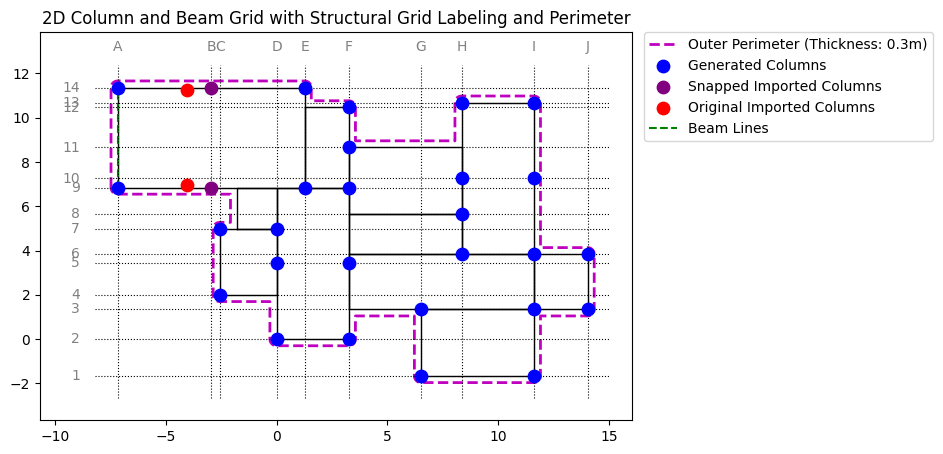

Widget(value='<iframe src="http://localhost:52103/index.html?ui=P_0x22001cd3ed0_2&reconnect=auto" class="pyvis…

In [3]:
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
import matplotlib.pyplot as plt
import os
import pyvista as pv

# File path
# Note: Using the remembered path from your previous interactions.
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0 # Global maximum Z for the entire building footprint

wall_breps = []

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y] # Ensure polygon is closed for Shapely
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        wall_breps.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z) # Update global max_z

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2 for ground + 1 middle + roof): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# --- Section for perimeter line and wall thickness ---
while True:
    try:
        wall_thickness = float(input("Enter desired wall thickness for the perimeter (e.g., 0.3): "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for wall thickness.")

# Combine all building polygons into a single MultiPolygon
combined_building_polygon = MultiPolygon(building_volumes)

# Get the exterior boundary of the combined building and offset it
try:
    exterior_perimeter = combined_building_polygon.buffer(wall_thickness, join_style=1) # join_style=1 for mitered joints
except Exception as e:
    print(f"Could not buffer the building outline. Error: {e}")
    exterior_perimeter = None

# If the buffer operation results in a MultiPolygon, get the largest component
if exterior_perimeter and exterior_perimeter.geom_type == 'MultiPolygon':
    exterior_perimeter = max(exterior_perimeter.geoms, key=lambda p: p.area)

perimeter_line_coords = []
if exterior_perimeter:
    if exterior_perimeter.geom_type == 'Polygon':
        # Extract the exterior ring coordinates
        perimeter_line_coords = list(exterior_perimeter.exterior.coords)
    elif exterior_perimeter.geom_type == 'MultiPolygon':
        # For MultiPolygon, take the exterior of the largest polygon component
        perimeter_line_coords = list(exterior_perimeter.geoms[0].exterior.coords)
    else:
        print("Warning: The buffered perimeter is not a Polygon or MultiPolygon. Cannot extract line coordinates.")

# --- End perimeter section ---

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# --- COLUMN GRID NUMBERING LOGIC ---
# Get unique X and Y coordinates from all generated/snapped columns for grid lines
grid_xs = sorted(list(set([col[0] for col in all_base_columns])))
grid_ys = sorted(list(set([col[1] for col in all_base_columns])))

# Create mapping for X-coordinates to letters (A, B, C...)
x_grid_labels = {x: chr(65 + i) for i, x in enumerate(grid_xs)}
# Create mapping for Y-coordinates to numbers (1, 2, 3...)
y_grid_labels = {y: i + 1 for i, y in enumerate(grid_ys)}

# Determine the actual min/max X/Y of the columns for drawing grid lines
col_min_x_extent = min(col[0] for col in all_base_columns) if all_base_columns else 0
col_max_x_extent = max(col[0] for col in all_base_columns) if all_base_columns else 0
col_min_y_extent = min(col[1] for col in all_base_columns) if all_base_columns else 0
col_max_y_extent = max(col[1] for col in all_base_columns) if all_base_columns else 0

# Add a small buffer to the column extents for drawing grid lines
grid_extent_buffer = 1.0 # Adjusted for better visual spacing
col_min_x_extent -= grid_extent_buffer
col_max_x_extent += grid_extent_buffer
col_min_y_extent -= grid_extent_buffer
col_max_y_extent += grid_extent_buffer

# Determine overall plot limits (consider building outline and grid labels)
# Adjusted limits to provide more space for labels without cutting off the perimeter
min_x_plot = min(col_min_x_extent, min([coord[0] for coord in perimeter_line_coords])) - 2.5 if perimeter_line_coords else col_min_x_extent - 2.5
max_x_plot = max(col_max_x_extent, max([coord[0] for coord in perimeter_line_coords])) + 1.0 if perimeter_line_coords else col_max_x_extent + 1.0
min_y_plot = min(col_min_y_extent, min([coord[1] for coord in perimeter_line_coords])) - 1.0 if perimeter_line_coords else col_min_y_extent - 1.0
max_y_plot = max(col_max_y_extent, max([coord[1] for coord in perimeter_line_coords])) + 1.5 if perimeter_line_coords else col_max_y_extent + 1.5


# 2D Visualization
fig, ax = plt.subplots(figsize=(12, 10)) # Increased figure width for legend

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Plot the new perimeter line
if perimeter_line_coords:
    px_perimeter, py_perimeter = zip(*perimeter_line_coords)
    ax.plot(px_perimeter, py_perimeter, 'm--', linewidth=2, label=f'Outer Perimeter (Thickness: {wall_thickness}m)')

# Plot all columns
gx, gy = zip(*columns)
ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

# Only draw one label for beam lines in 2D
if beams:
    x1, y1 = beams[0][0]
    x2, y2 = beams[0][1]
    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5, label='Beam Lines')

# Draw and label grid lines
# Increased offset for labels for better clarity
for x_coord in grid_xs:
    ax.plot([x_coord, x_coord], [col_min_y_extent, col_max_y_extent], 'k:', linewidth=0.8) # Dashed vertical grid line
    ax.text(x_coord, col_max_y_extent + 0.5, x_grid_labels[x_coord], ha='center', va='bottom', fontsize=10, color='gray') # Label at top

for y_coord in grid_ys:
    ax.plot([col_min_x_extent, col_max_x_extent], [y_coord, y_coord], 'k:', linewidth=0.8) # Dashed horizontal grid line
    ax.text(col_min_x_extent - 0.7, y_coord, y_grid_labels[y_coord], ha='right', va='center', fontsize=10, color='gray') # Label on left


ax.set_aspect('equal', 'box')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.) # Moved legend
plt.title("2D Column and Beam Grid with Structural Grid Labeling and Perimeter")
plt.tight_layout(rect=[0, 0, 0.8, 1]) # Adjust plot area to make space for legend and grid labels
ax.set_xlim(min_x_plot, max_x_plot)
ax.set_ylim(min_y_plot, max_y_plot)
plt.show()

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Define sizes for structural elements (now dimensions for rectangular prisms)
column_width = 0.3
column_depth = 0.3

beam_width = 0.25
beam_depth = 0.35

slab_thickness = 0.20

slab_extension_buffer = max(column_width, column_depth) / 2 + 0.05

# Calculate story heights per room, since rooms might have different max Z
room_story_heights = {}
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z
    
    num_vertical_sections = num_floors 

    if num_vertical_sections > 0:
        story_height = room_specific_max_z / num_vertical_sections
    else:
        story_height = room_specific_max_z
    
    room_story_heights[room_poly.wkt] = story_height


# --- Define Z-levels for each floor in a more structured way ---
floor_z_levels = {} 
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z

    current_room_floor_z = []
    
    # Slab 0: Ground Slab
    current_room_floor_z.append((0.0, slab_thickness))

    if num_floors > 0: # Only generate intermediate and roof slabs if there's at least 1 floor
        story_height = room_story_heights.get(room_poly.wkt, max_z)
        
        # Intermediate Slabs (from 1 to num_floors-1)
        for i in range(1, num_floors): 
            slab_base_z = i * story_height
            slab_top_z = slab_base_z + slab_thickness

            if slab_top_z > room_specific_max_z + 1e-6:
                slab_top_z = room_specific_max_z
                slab_base_z = max(slab_base_z, slab_top_z - slab_thickness)

            if slab_top_z - slab_base_z < 1e-6:
                continue
                
            current_room_floor_z.append((slab_base_z, slab_top_z))
        
        # Last Slab: Roof Slab
        roof_slab_top_z = room_specific_max_z 
        roof_slab_base_z = roof_slab_top_z - slab_thickness
        
        if current_room_floor_z:
            last_slab_top = current_room_floor_z[-1][1]
            if roof_slab_base_z < last_slab_top + 1e-6:
                roof_slab_base_z = last_slab_top
                roof_slab_top_z = roof_slab_base_z + slab_thickness
                if roof_slab_top_z > room_specific_max_z + 1e-6:
                    roof_slab_top_z = room_specific_max_z
                    roof_slab_base_z = max(roof_slab_top_z - slab_thickness, last_slab_top)
        
        if roof_slab_top_z - roof_slab_base_z < 1e-6:
            pass
        else:
            current_room_floor_z.append((roof_slab_base_z, roof_slab_top_z))

    floor_z_levels[room_poly.wkt] = current_room_floor_z

# --- Add Slabs ---
for room_poly, _ in detected_rooms:
    room_floor_data = floor_z_levels.get(room_poly.wkt, [])
    if not room_floor_data:
        continue

    extended_room_poly = room_poly.buffer(slab_extension_buffer)
    
    for i, (slab_base_z, slab_top_z) in enumerate(room_floor_data):
        current_slab_thickness = slab_top_z - slab_base_z
        if current_slab_thickness < 1e-6:
            continue

        points_3d_for_slab_base = []
        poly_coords = list(extended_room_poly.exterior.coords)
        if poly_coords[0] != poly_coords[-1]:
            poly_coords.append(poly_coords[0])
            
        for x, y in poly_coords:
            points_3d_for_slab_base.append([x, y, 0.0])
        
        points_3d_for_slab_base = np.array(points_3d_for_slab_base)

        if len(points_3d_for_slab_base) < 3:
            continue

        slab_base_mesh = pv.PolyData(points_3d_for_slab_base)
        
        try:
            triangulated_faces = slab_base_mesh.delaunay_2d().faces
            if triangulated_faces is None or len(triangulated_faces) == 0:
                continue
            slab_base_mesh = pv.PolyData(points_3d_for_slab_base, faces=triangulated_faces)
        except Exception as e:
            print(f"Delaunay triangulation failed for a slab base ({room_poly.bounds}): {e}. Skipping slab.")
            continue

        slab_mesh = slab_base_mesh.extrude(vector=(0, 0, current_slab_thickness), capping=True)
        slab_mesh = slab_mesh.translate((0, 0, slab_base_z))
        
        plotter.add_mesh(slab_mesh, color='sienna', opacity=0.8, smooth_shading=True)


# --- Add Columns ---
for x, y in all_base_columns:
    column_room_wkt = None
    for room_poly, _ in detected_rooms:
        if Point(x, y).within(room_poly):
            column_room_wkt = room_poly.wkt
            break
    if column_room_wkt is None:
        min_dist = float('inf')
        for room_poly, _ in detected_rooms:
            dist = Point(x,y).distance(room_poly)
            if dist < min_dist:
                min_dist = dist
                column_room_wkt = room_poly.wkt
        if column_room_wkt is None:
             continue

    room_floor_data = floor_z_levels.get(column_room_wkt, [])
    if not room_floor_data or len(room_floor_data) <= 1:
        continue
    
    num_slabs_in_room = len(room_floor_data)
    
    for i in range(num_slabs_in_room - 1):
        col_base_z = room_floor_data[i][1] 
        col_top_z = room_floor_data[i+1][0] 

        if col_top_z <= col_base_z + 1e-6:
            continue

        col_min_x = x - column_width / 2
        col_max_x = x + column_width / 2
        col_min_y = y - column_depth / 2
        col_max_y = y + column_depth / 2
        
        column_box = pv.Box([col_min_x, col_max_x, col_min_y, col_max_y, col_base_z, col_top_z])
        plotter.add_mesh(column_box, color='blue', smooth_shading=True)


# --- Add Beams ---
for (x1, y1), (x2, y2) in beams:
    full_beam_line = LineString([(x1, y1), (x2, y2)])

    for i in range(len(room_floor_data)):
        relevant_rooms_for_this_floor = []
        for room_poly, _ in detected_rooms:
            if room_poly.intersects(full_beam_line.buffer(1e-3)):
                room_floor_data_current_room = floor_z_levels.get(room_poly.wkt, [])
                if len(room_floor_data_current_room) > i:
                    slab_base_z_for_this_room_floor = room_floor_data_current_room[i][0]
                    slab_top_z_for_this_room_floor = room_floor_data_current_room[i][1]

                    room_specific_max_z = 0.0
                    for wall_data in wall_breps:
                        if wall_data['polygon'].equals(room_poly):
                            room_specific_max_z = wall_data['bbox'].Max.Z
                            break
                    if room_specific_max_z == 0.0: room_specific_max_z = max_z

                    if slab_base_z_for_this_room_floor >= room_specific_max_z - 1e-6 and i < len(room_floor_data_current_room) -1:
                        continue 
                    
                    relevant_rooms_for_this_floor.append((room_poly, slab_base_z_for_this_room_floor))

        if not relevant_rooms_for_this_floor:
            continue

        for room_poly, slab_base_z_for_current_room in relevant_rooms_for_this_floor:
            intersection = full_beam_line.intersection(room_poly)

            if intersection.geom_type == 'LineString':
                segments_to_draw = [intersection]
            elif intersection.geom_type == 'MultiLineString':
                segments_to_draw = list(intersection.geoms)
            else: 
                continue

            for segment in segments_to_draw:
                if not segment.is_empty and segment.length > 1e-6:
                    seg_x1, seg_y1 = segment.coords[0]
                    seg_x2, seg_y2 = segment.coords[-1]

                    beam_top_z = slab_base_z_for_current_room
                    beam_base_z = beam_top_z - beam_depth

                    if beam_base_z < 0:
                        beam_base_z = 0
                        if beam_top_z <= 0:
                            continue
                    
                    if beam_top_z <= beam_base_z + 1e-6:
                        continue

                    if abs(seg_x1 - seg_x2) > abs(seg_y1 - seg_y2):
                        beam_min_x = min(seg_x1, seg_x2)
                        beam_max_x = max(seg_x1, seg_x2)
                        beam_center_y = (seg_y1 + seg_y2) / 2
                        beam_min_y = beam_center_y - beam_width / 2
                        beam_max_y = beam_center_y + beam_width / 2
                    else:
                        beam_min_y = min(seg_y1, seg_y2)
                        beam_max_y = max(seg_y1, seg_y2)
                        beam_center_x = (seg_x1 + seg_x2) / 2
                        beam_min_x = beam_center_x - beam_width / 2
                        beam_max_x = beam_center_x + beam_width / 2

                    beam_box = pv.Box([beam_min_x, beam_max_x, beam_min_y, beam_max_y, beam_base_z, beam_top_z])

                    is_roof_slab = (i == len(room_floor_data_current_room) - 1)
                    color = 'green' if is_roof_slab else 'orange' 
                    plotter.add_mesh(beam_box, color=color, smooth_shading=True)


# Actual Brep-based walls visualization (semi-transparent)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

plotter.show_grid()
plotter.show()

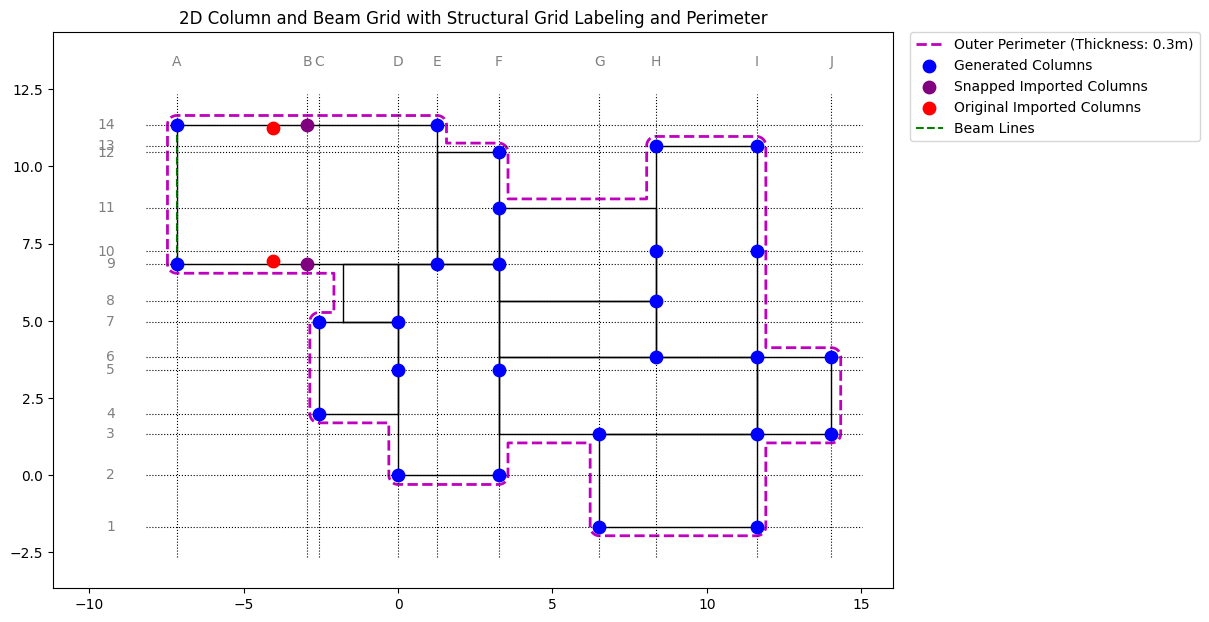

Widget(value='<iframe src="http://localhost:59281/index.html?ui=P_0x11ee37f4910_16&reconnect=auto" class="pyvi…

In [ ]:
#correct oneeeeeeeeeeeeeee

import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
import matplotlib.pyplot as plt
import os
import pyvista as pv

# File path
# Note: Using the remembered path from your previous interactions.
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0 # Global maximum Z for the entire building footprint

wall_breps = []

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y] # Ensure polygon is closed for Shapely
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        wall_breps.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z) # Update global max_z

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2 for ground + 1 middle + roof): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# --- Section for perimeter line and wall thickness ---
while True:
    try:
        wall_thickness = float(input("Enter desired wall thickness for the perimeter (e.g., 0.3): "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for wall thickness.")

# Combine all building polygons into a single MultiPolygon
combined_building_polygon = MultiPolygon(building_volumes)

# Get the exterior boundary of the combined building and offset it
try:
    exterior_perimeter = combined_building_polygon.buffer(wall_thickness, join_style=1) # join_style=1 for mitered joints
except Exception as e:
    print(f"Could not buffer the building outline. Error: {e}")
    exterior_perimeter = None

# If the buffer operation results in a MultiPolygon, get the largest component
if exterior_perimeter and exterior_perimeter.geom_type == 'MultiPolygon':
    exterior_perimeter = max(exterior_perimeter.geoms, key=lambda p: p.area)

perimeter_line_coords = []
if exterior_perimeter:
    if exterior_perimeter.geom_type == 'Polygon':
        # Extract the exterior ring coordinates
        perimeter_line_coords = list(exterior_perimeter.exterior.coords)
    elif exterior_perimeter.geom_type == 'MultiPolygon':
        # For MultiPolygon, take the exterior of the largest polygon component
        perimeter_line_coords = list(exterior_perimeter.geoms[0].exterior.coords)
    else:
        print("Warning: The buffered perimeter is not a Polygon or MultiPolygon. Cannot extract line coordinates.")

# --- End perimeter section ---

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# --- COLUMN GRID NUMBERING LOGIC ---
# Get unique X and Y coordinates from all generated/snapped columns for grid lines
grid_xs = sorted(list(set([col[0] for col in all_base_columns])))
grid_ys = sorted(list(set([col[1] for col in all_base_columns])))

# Create mapping for X-coordinates to letters (A, B, C...)
x_grid_labels = {x: chr(65 + i) for i, x in enumerate(grid_xs)}
# Create mapping for Y-coordinates to numbers (1, 2, 3...)
y_grid_labels = {y: i + 1 for i, y in enumerate(grid_ys)}

# Determine the actual min/max X/Y of the columns for drawing grid lines
col_min_x_extent = min(col[0] for col in all_base_columns) if all_base_columns else 0
col_max_x_extent = max(col[0] for col in all_base_columns) if all_base_columns else 0
col_min_y_extent = min(col[1] for col in all_base_columns) if all_base_columns else 0
col_max_y_extent = max(col[1] for col in all_base_columns) if all_base_columns else 0

# Add a small buffer to the column extents for drawing grid lines
grid_extent_buffer = 1.0 # Adjusted for better visual spacing
col_min_x_extent -= grid_extent_buffer
col_max_x_extent += grid_extent_buffer
col_min_y_extent -= grid_extent_buffer
col_max_y_extent += grid_extent_buffer

# Determine overall plot limits (consider building outline and grid labels)
# Adjusted limits to provide more space for labels without cutting off the perimeter
# Increased padding for labels
min_x_plot = min(col_min_x_extent, min([coord[0] for coord in perimeter_line_coords] + [col[0] for col in all_base_columns])) - 3.0 if perimeter_line_coords else col_min_x_extent - 3.0
max_x_plot = max(col_max_x_extent, max([coord[0] for coord in perimeter_line_coords] + [col[0] for col in all_base_columns])) + 1.0 if perimeter_line_coords else col_max_x_extent + 1.0
min_y_plot = min(col_min_y_extent, min([coord[1] for coord in perimeter_line_coords] + [col[1] for col in all_base_columns])) - 1.0 if perimeter_line_coords else col_min_y_extent - 1.0
max_y_plot = max(col_max_y_extent, max([coord[1] for coord in perimeter_line_coords] + [col[1] for col in all_base_columns])) + 2.0 if perimeter_line_coords else col_max_y_extent + 2.0


# 2D Visualization
fig, ax = plt.subplots(figsize=(12, 10)) # Increased figure width for legend

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Plot the new perimeter line
if perimeter_line_coords:
    px_perimeter, py_perimeter = zip(*perimeter_line_coords)
    ax.plot(px_perimeter, py_perimeter, 'm--', linewidth=2, label=f'Outer Perimeter (Thickness: {wall_thickness}m)')

# Plot all columns
gx, gy = zip(*columns)
ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

# Only draw one label for beam lines in 2D
if beams:
    x1, y1 = beams[0][0]
    x2, y2 = beams[0][1]
    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5, label='Beam Lines')

# Draw and label grid lines
# Increased offset for labels for better clarity
for x_coord in grid_xs:
    ax.plot([x_coord, x_coord], [col_min_y_extent, col_max_y_extent], 'k:', linewidth=0.8) # Dashed vertical grid line
    ax.text(x_coord, col_max_y_extent + 0.8, x_grid_labels[x_coord], ha='center', va='bottom', fontsize=10, color='gray') # Label at top

for y_coord in grid_ys:
    ax.plot([col_min_x_extent, col_max_x_extent], [y_coord, y_coord], 'k:', linewidth=0.8) # Dashed horizontal grid line
    ax.text(col_min_x_extent - 1.0, y_coord, y_grid_labels[y_coord], ha='right', va='center', fontsize=10, color='gray') # Label on left


ax.set_aspect('equal', 'box')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.) # Moved legend
plt.title("2D Column and Beam Grid with Structural Grid Labeling and Perimeter")

# Using subplots_adjust for explicit margin control instead of tight_layout
# This gives more precise control over the margins for labels
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1) # Adjusted values for left and top margin


ax.set_xlim(min_x_plot, max_x_plot)
ax.set_ylim(min_y_plot, max_y_plot)
plt.show()

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Define sizes for structural elements (now dimensions for rectangular prisms)
column_width = 0.3
column_depth = 0.3

beam_width = 0.25
beam_depth = 0.35

slab_thickness = 0.20

slab_extension_buffer = max(column_width, column_depth) / 2 + 0.05

# Calculate story heights per room, since rooms might have different max Z
room_story_heights = {}
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z
    
    num_vertical_sections = num_floors 

    if num_vertical_sections > 0:
        story_height = room_specific_max_z / num_vertical_sections
    else:
        story_height = room_specific_max_z
    
    room_story_heights[room_poly.wkt] = story_height


# --- Define Z-levels for each floor in a more structured way ---
floor_z_levels = {} 
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z

    current_room_floor_z = []
    
    # Slab 0: Ground Slab
    current_room_floor_z.append((0.0, slab_thickness))

    if num_floors > 0: # Only generate intermediate and roof slabs if there's at least 1 floor
        story_height = room_story_heights.get(room_poly.wkt, max_z)
        
        # Intermediate Slabs (from 1 to num_floors-1)
        for i in range(1, num_floors): 
            slab_base_z = i * story_height
            slab_top_z = slab_base_z + slab_thickness

            if slab_top_z > room_specific_max_z + 1e-6:
                slab_top_z = room_specific_max_z
                slab_base_z = max(slab_base_z, slab_top_z - slab_thickness)

            if slab_top_z - slab_base_z < 1e-6:
                continue
                
            current_room_floor_z.append((slab_base_z, slab_top_z))
        
        # Last Slab: Roof Slab
        roof_slab_top_z = room_specific_max_z 
        roof_slab_base_z = roof_slab_top_z - slab_thickness
        
        if current_room_floor_z:
            last_slab_top = current_room_floor_z[-1][1]
            if roof_slab_base_z < last_slab_top + 1e-6:
                roof_slab_base_z = last_slab_top
                roof_slab_top_z = roof_slab_base_z + slab_thickness
                if roof_slab_top_z > room_specific_max_z + 1e-6:
                    roof_slab_top_z = room_specific_max_z
                    roof_slab_base_z = max(roof_slab_top_z - slab_thickness, last_slab_top)
        
        if roof_slab_top_z - roof_slab_base_z < 1e-6:
            pass
        else:
            current_room_floor_z.append((roof_slab_base_z, roof_slab_top_z))

    floor_z_levels[room_poly.wkt] = current_room_floor_z

# --- Add Slabs ---
for room_poly, _ in detected_rooms:
    room_floor_data = floor_z_levels.get(room_poly.wkt, [])
    if not room_floor_data:
        continue

    extended_room_poly = room_poly.buffer(slab_extension_buffer)
    
    for i, (slab_base_z, slab_top_z) in enumerate(room_floor_data):
        current_slab_thickness = slab_top_z - slab_base_z
        if current_slab_thickness < 1e-6:
            continue

        points_3d_for_slab_base = []
        poly_coords = list(extended_room_poly.exterior.coords)
        if poly_coords[0] != poly_coords[-1]:
            poly_coords.append(poly_coords[0])
            
        for x, y in poly_coords:
            points_3d_for_slab_base.append([x, y, 0.0])
        
        points_3d_for_slab_base = np.array(points_3d_for_slab_base)

        if len(points_3d_for_slab_base) < 3:
            continue

        slab_base_mesh = pv.PolyData(points_3d_for_slab_base)
        
        try:
            triangulated_faces = slab_base_mesh.delaunay_2d().faces
            if triangulated_faces is None or len(triangulated_faces) == 0:
                continue
            slab_base_mesh = pv.PolyData(points_3d_for_slab_base, faces=triangulated_faces)
        except Exception as e:
            print(f"Delaunay triangulation failed for a slab base ({room_poly.bounds}): {e}. Skipping slab.")
            continue

        slab_mesh = slab_base_mesh.extrude(vector=(0, 0, current_slab_thickness), capping=True)
        slab_mesh = slab_mesh.translate((0, 0, slab_base_z))
        
        plotter.add_mesh(slab_mesh, color='sienna', opacity=0.8, smooth_shading=True)


# --- Add Columns ---
for x, y in all_base_columns:
    column_room_wkt = None
    for room_poly, _ in detected_rooms:
        if Point(x, y).within(room_poly):
            column_room_wkt = room_poly.wkt
            break
    if column_room_wkt is None:
        min_dist = float('inf')
        for room_poly, _ in detected_rooms:
            dist = Point(x,y).distance(room_poly)
            if dist < min_dist:
                min_dist = dist
                column_room_wkt = room_poly.wkt
        if column_room_wkt is None:
             continue

    room_floor_data = floor_z_levels.get(column_room_wkt, [])
    if not room_floor_data or len(room_floor_data) <= 1:
        continue
    
    num_slabs_in_room = len(room_floor_data)
    
    for i in range(num_slabs_in_room - 1):
        col_base_z = room_floor_data[i][1] 
        col_top_z = room_floor_data[i+1][0] 

        if col_top_z <= col_base_z + 1e-6:
            continue

        col_min_x = x - column_width / 2
        col_max_x = x + column_width / 2
        col_min_y = y - column_depth / 2
        col_max_y = y + column_depth / 2
        
        column_box = pv.Box([col_min_x, col_max_x, col_min_y, col_max_y, col_base_z, col_top_z])
        plotter.add_mesh(column_box, color='blue', smooth_shading=True)


# --- Add Beams ---
for (x1, y1), (x2, y2) in beams:
    full_beam_line = LineString([(x1, y1), (x2, y2)])

    for i in range(len(room_floor_data)):
        relevant_rooms_for_this_floor = []
        for room_poly, _ in detected_rooms:
            if room_poly.intersects(full_beam_line.buffer(1e-3)):
                room_floor_data_current_room = floor_z_levels.get(room_poly.wkt, [])
                if len(room_floor_data_current_room) > i:
                    slab_base_z_for_this_room_floor = room_floor_data_current_room[i][0]
                    slab_top_z_for_this_room_floor = room_floor_data_current_room[i][1]

                    room_specific_max_z = 0.0
                    for wall_data in wall_breps:
                        if wall_data['polygon'].equals(room_poly):
                            room_specific_max_z = wall_data['bbox'].Max.Z
                            break
                    if room_specific_max_z == 0.0: room_specific_max_z = max_z

                    if slab_base_z_for_this_room_floor >= room_specific_max_z - 1e-6 and i < len(room_floor_data_current_room) -1:
                        continue 
                    
                    relevant_rooms_for_this_floor.append((room_poly, slab_base_z_for_this_room_floor))

        if not relevant_rooms_for_this_floor:
            continue

        for room_poly, slab_base_z_for_current_room in relevant_rooms_for_this_floor:
            intersection = full_beam_line.intersection(room_poly)

            if intersection.geom_type == 'LineString':
                segments_to_draw = [intersection]
            elif intersection.geom_type == 'MultiLineString':
                segments_to_draw = list(intersection.geoms)
            else: 
                continue

            for segment in segments_to_draw:
                if not segment.is_empty and segment.length > 1e-6:
                    seg_x1, seg_y1 = segment.coords[0]
                    seg_x2, seg_y2 = segment.coords[-1]

                    beam_top_z = slab_base_z_for_current_room
                    beam_base_z = beam_top_z - beam_depth

                    if beam_base_z < 0:
                        beam_base_z = 0
                        if beam_top_z <= 0:
                            continue
                    
                    if beam_top_z <= beam_base_z + 1e-6:
                        continue

                    if abs(seg_x1 - seg_x2) > abs(seg_y1 - seg_y2):
                        beam_min_x = min(seg_x1, seg_x2)
                        beam_max_x = max(seg_x1, seg_x2)
                        beam_center_y = (seg_y1 + seg_y2) / 2
                        beam_min_y = beam_center_y - beam_width / 2
                        beam_max_y = beam_center_y + beam_width / 2
                    else:
                        beam_min_y = min(seg_y1, seg_y2)
                        beam_max_y = max(seg_y1, seg_y2)
                        beam_center_x = (seg_x1 + seg_x2) / 2
                        beam_min_x = beam_center_x - beam_width / 2
                        beam_max_x = beam_center_x + beam_width / 2

                    beam_box = pv.Box([beam_min_x, beam_max_x, beam_min_y, beam_max_y, beam_base_z, beam_top_z])

                    is_roof_slab = (i == len(room_floor_data_current_room) - 1)
                    color = 'green' if is_roof_slab else 'orange' 
                    plotter.add_mesh(beam_box, color=color, smooth_shading=True)


# Actual Brep-based walls visualization (semi-transparent)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

plotter.show_grid()
plotter.show()

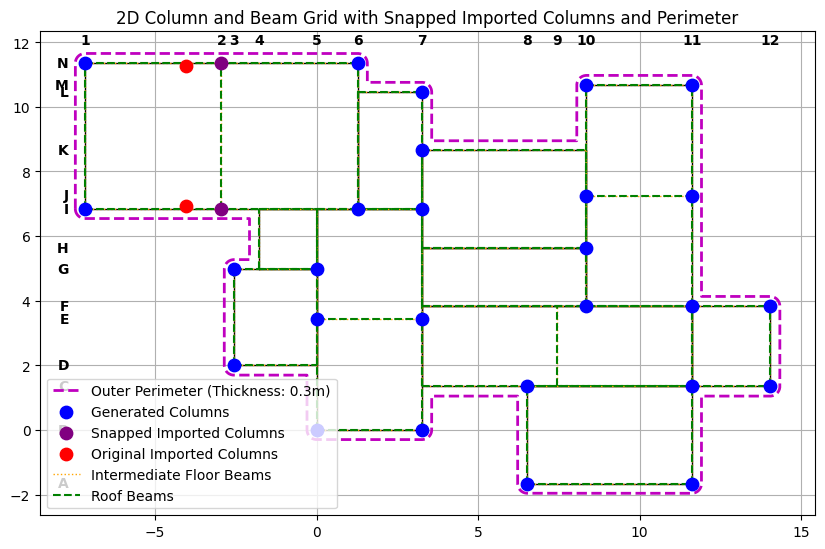

Widget(value='<iframe src="http://localhost:59281/index.html?ui=P_0x11eb4e41d10_1&reconnect=auto" class="pyvis…

In [2]:
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
# Note: Using the remembered path from your previous interactions.
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0 # Global maximum Z for the entire building footprint

wall_breps = []

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Min.Y] # Ensure polygon is closed for Shapely
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        wall_breps.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z) # Update global max_z

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# --- Section for perimeter line and wall thickness ---
while True:
    try:
        wall_thickness = float(input("Enter desired wall thickness for the perimeter (e.g., 0.3): "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for wall thickness.")

# Combine all building polygons into a single MultiPolygon
combined_building_polygon = MultiPolygon(building_volumes)

# Get the exterior boundary of the combined building and offset it
try:
    exterior_perimeter = combined_building_polygon.buffer(wall_thickness, join_style=1) # join_style=1 for mitered joints
except Exception as e:
    print(f"Could not buffer the building outline. Error: {e}")
    exterior_perimeter = None

# If the buffer operation results in a MultiPolygon, get the largest component
if exterior_perimeter and exterior_perimeter.geom_type == 'MultiPolygon':
    exterior_perimeter = max(exterior_perimeter.geoms, key=lambda p: p.area)

perimeter_line_coords = []
if exterior_perimeter:
    if exterior_perimeter.geom_type == 'Polygon':
        # Extract the exterior ring coordinates
        perimeter_line_coords = list(exterior_perimeter.exterior.coords)
    elif exterior_perimeter.geom_type == 'MultiPolygon':
        # For MultiPolygon, take the exterior of the largest polygon component
        perimeter_line_coords = list(exterior_perimeter.geoms[0].exterior.coords)
    else:
        print("Warning: The buffered perimeter is not a Polygon or MultiPolygon. Cannot extract line coordinates.")

# --- End perimeter section ---

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# --- Add grid labels like Revit ---

# Get all X and Y values used in grid
x_labels = sorted(set([pt[0] for (pt, _) in beams if isinstance(pt, tuple)]))
y_labels = sorted(set([pt[1] for (_, pt) in beams if isinstance(pt, tuple)]))

# Label columns at top (X-axis)
for i, x in enumerate(x_labels):
    ax.text(x, max(y_labels) + 0.5, f"{i+1}", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Label rows at left (Y-axis)
for j, y in enumerate(y_labels):
    ax.text(min(x_labels) - 0.5, y, chr(65 + j), ha='right', va='center', fontsize=10, fontweight='bold')


# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Plot the new perimeter line
if perimeter_line_coords:
    px_perimeter, py_perimeter = zip(*perimeter_line_coords)
    ax.plot(px_perimeter, py_perimeter, 'm--', linewidth=2, label=f'Outer Perimeter (Thickness: {wall_thickness}m)')


# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor_num in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                            label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns and Perimeter")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data):
    pt = np.array([x, y])
    closest_wall = None
    closest_dist = float('inf')

    for wall in wall_data:
        poly = wall['polygon']
        dist = poly.exterior.distance(Point(x, y))
        if dist < closest_dist:
            closest_dist = dist
            closest_wall = wall

    if closest_wall:
        return closest_wall['bbox'].Max.Z
    else:
        return max_z  # fallback to global max_z

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Define sizes for structural elements (now dimensions for rectangular prisms)
column_width = 0.3 # Example: 30cm x 30cm columns
column_depth = 0.3

# Updated beam and slab thicknesses
beam_width = 0.2 - 0.05 # 0.05 thinner
beam_depth = 0.4 - 0.05 # 0.05 thinner

slab_thickness = 0.15 + 0.05 # 0.05 thicker

# A small buffer to extend the slabs to cover the columns
# This should be at least half the column's dimension + a small tolerance
slab_extension_buffer = max(column_width, column_depth) / 2 + 0.01 + 0.005 # Added extra 0.005

# Columns as rectangular prisms
for x, y in all_base_columns:
    wall_height = get_wall_height(x, y, wall_breps)
    # Calculate min/max for the column's bounding box
    col_min_x = x - column_width / 2
    col_max_x = x + column_width / 2
    col_min_y = y - column_depth / 2
    col_max_y = y + column_depth / 2
    col_min_z = 0 # Columns start from ground
    col_max_z = wall_height # Columns go up to the building's height

    column_box = pv.Box([col_min_x, col_max_x, col_min_y, col_max_y, col_min_z, col_max_z])
    plotter.add_mesh(column_box, color='blue', smooth_shading=True)

# Beams as rectangular prisms
for (x1, y1), (x2, y2) in beams:
    h1 = get_wall_height(x1, y1, wall_breps)
    h2 = get_wall_height(x2, y2, wall_breps)
    floor_height_for_beams_segment = min(h1, h2)

    for floor_num in range(1, num_floors + 1):
        # Calculate the intended Z-level for the TOP surface of the slab this beam supports
        # This is (floor_num / num_floors) * max_z to get the ratio of total height for this floor
        # For the roof, this will naturally be max_z
        intended_slab_top_z_for_beam = (floor_num / num_floors) * floor_height_for_beams_segment

        # The top of the beam should align with the bottom of the slab
        beam_max_z = intended_slab_top_z_for_beam - slab_thickness
        beam_min_z = beam_max_z - beam_depth

        # Ensure beam_min_z is not negative (below ground)
        if beam_min_z < 0:
            beam_min_z = 0
            beam_max_z = beam_depth # Adjust max_z to maintain depth from ground

        # Skip beams if they (or their tops) would exceed the actual height of the wall segment
        if beam_max_z > (floor_height_for_beams_segment + 1e-6): # Compare against the specific segment height
            continue

        # Determine beam orientation (X or Y)
        if abs(x1 - x2) > abs(y1 - y2): # X-oriented beam
            beam_min_x = min(x1, x2)
            beam_max_x = max(x1, x2)
            beam_center_y = (y1 + y2) / 2
            beam_min_y = beam_center_y - beam_width / 2
            beam_max_y = beam_center_y + beam_width / 2
        else: # Y-oriented beam
            beam_min_y = min(y1, y2)
            beam_max_y = max(y1, y2)
            beam_center_x = (x1 + x2) / 2
            beam_min_x = beam_center_x - beam_width / 2
            beam_max_x = beam_center_x + beam_width / 2

        beam_box = pv.Box([beam_min_x, beam_max_x, beam_min_y, beam_max_y, beam_min_z, beam_max_z])

        color = 'green' if floor_num == num_floors else 'orange'
        plotter.add_mesh(beam_box, color=color, smooth_shading=True)

# Add slabs - REVISED SECTION
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z

    if num_floors <= 0:
        continue # No floors, no slabs

    # Apply a small buffer to the room polygon to extend the slab
    extended_room_poly = room_poly.buffer(slab_extension_buffer)

    # Calculate height of each story *for this room's total height*
    # This is the actual height of one story for this specific room geometry
    story_height = room_specific_max_z / num_floors

    for i in range(1, num_floors + 1): # loop for each floor, 1 to num_floors
        # Calculate the intended Z-level for the TOP surface of the current slab
        intended_slab_top_z = i * story_height
        
        # The base of the slab is its intended top surface Z minus its thickness
        slab_base_z = intended_slab_top_z - slab_thickness

        # Ensure slab_base_z isn't below 0 (ground level)
        if slab_base_z < 0:
            slab_base_z = 0
            # If the base starts at 0, the thickness should be adjusted to reach the intended top Z
            current_slab_thickness_for_this_level = intended_slab_top_z
        else:
            current_slab_thickness_for_this_level = slab_thickness
        
        # Final check to ensure the slab doesn't extend beyond the room's max height
        # This is especially important for the top floor to not exceed the actual building height
        if (slab_base_z + current_slab_thickness_for_this_level) > (room_specific_max_z + 1e-6):
            current_slab_thickness_for_this_level = max(0, room_specific_max_z - slab_base_z)
            if current_slab_thickness_for_this_level < 1e-6:
                continue # Skip drawing if thickness is negligible

        # Convert 2D shapely polygon coordinates to 3D points (X, Y, Z=0 for base plane) for PyVista
        points_3d_for_slab_base = []
        # Use the extended_room_poly for slab generation
        poly_coords = list(extended_room_poly.exterior.coords)
        if poly_coords[0] != poly_coords[-1]:
            poly_coords.append(poly_coords[0]) # Close the loop
            
        for x, y in poly_coords:
            points_3d_for_slab_base.append([x, y, 0.0]) # Add a Z-coordinate (0 for the base plane)
        
        points_3d_for_slab_base = np.array(points_3d_for_slab_base)

        if len(points_3d_for_slab_base) < 3: # Need at least 3 points for a polygon
            continue

        slab_base_mesh = pv.PolyData(points_3d_for_slab_base) # Pass the (N,3) array
        
        # Triangulate the 2D base polygon for extrusion
        try:
            triangulated_faces = slab_base_mesh.delaunay_2d().faces
            if triangulated_faces is None or len(triangulated_faces) == 0:
                print(f"Skipping slab due to empty triangulation for polygon {room_poly.bounds}")
                continue
            slab_base_mesh = pv.PolyData(points_3d_for_slab_base, faces=triangulated_faces) # Recreate with faces
        except Exception as e:
            print(f"Delaunay triangulation failed for a slab base ({room_poly.bounds}): {e}. Skipping slab.")
            continue

        # Extrude the triangulated base to create the 3D slab
        slab_mesh = slab_base_mesh.extrude(vector=(0, 0, current_slab_thickness_for_this_level), capping=True)
        slab_mesh = slab_mesh.translate((0, 0, slab_base_z)) # Move the slab to its correct Z level
        
        plotter.add_mesh(slab_mesh, color='sienna', opacity=0.8, smooth_shading=True)

# Add the perimeter line in 3D (at base level)
if perimeter_line_coords:
    # Convert 2D coordinates to 3D at Z=0 for the base perimeter
    perimeter_3d_points = [[x, y, 0] for x, y in perimeter_line_coords]
    
    # Create a PolyData object for the line segments
    lines = []
    for i in range(len(perimeter_3d_points) - 1):
        lines.extend([2, i, i + 1])
    # Close the loop (connect last point to first)
    if len(perimeter_3d_points) > 1:
        lines.extend([2, len(perimeter_3d_points) - 1, 0])

    perimeter_polydata = pv.PolyData(perimeter_3d_points, lines=lines)
    plotter.add_mesh(perimeter_polydata, color='magenta', line_width=5, render_lines_as_tubes=True, label="Outer Perimeter Line")

# Actual Brep-based walls visualization (semi-transparent)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show the 3D plot
plotter.show_grid()
plotter.show()

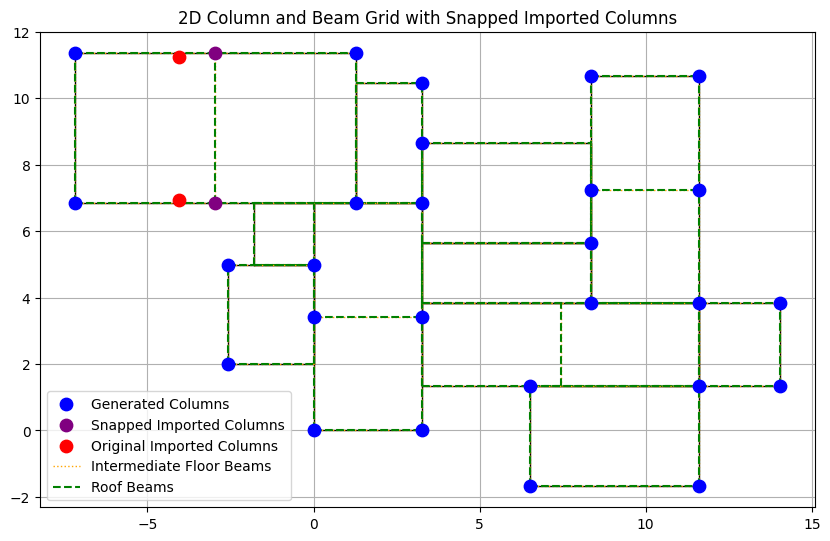

Widget(value='<iframe src="http://localhost:59281/index.html?ui=P_0x11ec2acd950_2&reconnect=auto" class="pyvis…

In [3]:
# DONT TOUCH

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0

wall_breps = []

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        wall_breps.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data):
    pt = np.array([x, y])
    closest_wall = None
    closest_dist = float('inf')

    for wall in wall_data:
        poly = wall['polygon']
        dist = poly.exterior.distance(Point(x, y))
        if dist < closest_dist:
            closest_dist = dist
            closest_wall = wall

    if closest_wall:
        return closest_wall['bbox'].Max.Z
    else:
        return max_z  # fallback


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    wall_height = get_wall_height(x, y, wall_breps)
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                       radius=0.1, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04  # thinner than column radius 0.1

for (x1, y1), (x2, y2) in beams:
    h1 = get_wall_height(x1, y1, wall_breps)
    h2 = get_wall_height(x2, y2, wall_breps)
    floor_height = min(h1, h2)

    for floor in range(1, num_floors + 1):
        z = floor_height / num_floors * floor

        # Skip beams above wall height (important for cantilevers or partial-height volumes)
        if z > h1 or z > h2:
            continue

        start = np.array([x1, y1, z])
        end = np.array([x2, y2, z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)



# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

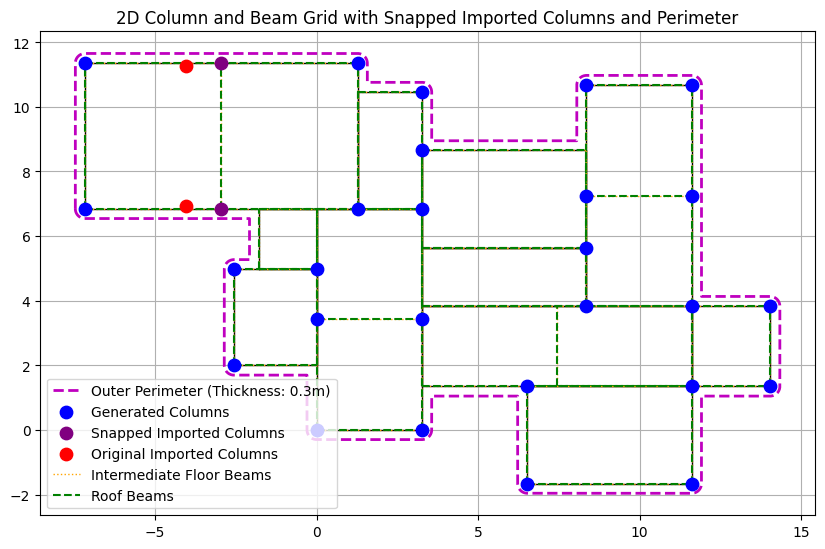

Widget(value='<iframe src="http://localhost:55784/index.html?ui=P_0x272559e1590_17&reconnect=auto" class="pyvi…

In [20]:
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
# Note: Using the remembered path from your previous interactions.
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0 # Global maximum Z for the entire building footprint

wall_breps = []

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        wall_breps.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z) # Update global max_z

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# --- Section for perimeter line and wall thickness ---
while True:
    try:
        wall_thickness = float(input("Enter desired wall thickness for the perimeter (e.g., 0.3): "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for wall thickness.")

# Combine all building polygons into a single MultiPolygon
combined_building_polygon = MultiPolygon(building_volumes)

# Get the exterior boundary of the combined building and offset it
try:
    exterior_perimeter = combined_building_polygon.buffer(wall_thickness, join_style=1) # join_style=1 for mitered joints
except Exception as e:
    print(f"Could not buffer the building outline. Error: {e}")
    exterior_perimeter = None

# If the buffer operation results in a MultiPolygon, get the largest component
if exterior_perimeter and exterior_perimeter.geom_type == 'MultiPolygon':
    exterior_perimeter = max(exterior_perimeter.geoms, key=lambda p: p.area)

perimeter_line_coords = []
if exterior_perimeter:
    if exterior_perimeter.geom_type == 'Polygon':
        # Extract the exterior ring coordinates
        perimeter_line_coords = list(exterior_perimeter.exterior.coords)
    elif exterior_perimeter.geom_type == 'MultiPolygon':
        # For MultiPolygon, take the exterior of the largest polygon component
        perimeter_line_coords = list(exterior_perimeter.geoms[0].exterior.coords)
    else:
        print("Warning: The buffered perimeter is not a Polygon or MultiPolygon. Cannot extract line coordinates.")

# --- End perimeter section ---

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Plot the new perimeter line
if perimeter_line_coords:
    px_perimeter, py_perimeter = zip(*perimeter_line_coords)
    ax.plot(px_perimeter, py_perimeter, 'm--', linewidth=2, label=f'Outer Perimeter (Thickness: {wall_thickness}m)')


# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor_num in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns and Perimeter")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data):
    pt = np.array([x, y])
    closest_wall = None
    closest_dist = float('inf')

    for wall in wall_data:
        poly = wall['polygon']
        dist = poly.exterior.distance(Point(x, y))
        if dist < closest_dist:
            closest_dist = dist
            closest_wall = wall

    if closest_wall:
        return closest_wall['bbox'].Max.Z
    else:
        return max_z  # fallback to global max_z

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Define sizes for structural elements
column_radius = 0.15 # Changed from 0.1
beam_radius = 0.1   # Changed from 0.04
slab_thickness = 0.15

# Columns as vertical cylinders
for x, y in all_base_columns:
    wall_height = get_wall_height(x, y, wall_breps)
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                           radius=column_radius, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as cylinders
for (x1, y1), (x2, y2) in beams:
    h1 = get_wall_height(x1, y1, wall_breps)
    h2 = get_wall_height(x2, y2, wall_breps)
    floor_height_for_beams = min(h1, h2) # Represents the effective height for beam placement within this segment

    for floor_num in range(1, num_floors + 1): # Beams are drawn for each floor level (1 to num_floors)
        # Z for the center of the beam
        beam_z = floor_height_for_beams / num_floors * floor_num

        # Skip beams if they exceed the actual height of the wall segment
        if beam_z > h1 or beam_z > h2:
            continue

        start = np.array([x1, y1, beam_z])
        end = np.array([x2, y2, beam_z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6: # Avoid division by zero for zero-length beams
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor_num == num_floors else 'orange' # Green for roof beams, orange for intermediate
        plotter.add_mesh(beam, color=color)

# Add slabs
for room_poly, _ in detected_rooms:
    # Get the specific max Z for this room's bounding box
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0: # Fallback, though should be covered by bbox finding
        room_specific_max_z = max_z

    if num_floors > 0:
        # Calculate the height of each story for this room
        effective_story_height = room_specific_max_z / num_floors
    else:
        effective_story_height = 0 # Should not happen due to num_floors validation

    # Create num_floors + 1 slabs:
    # i=0 for ground slab, i=1 for 1st floor slab, ..., i=num_floors for roof slab
    for i in range(num_floors + 1):
        slab_base_z = i * effective_story_height

        # Adjust slab thickness for the top-most slab or if it exceeds room height
        current_slab_thickness_for_this_level = slab_thickness
        if slab_base_z + slab_thickness > room_specific_max_z + 1e-6: # Add tolerance for float comparison
            # If the full slab would extend beyond the room's defined height,
            # clamp its thickness so its top aligns with room_specific_max_z.
            current_slab_thickness_for_this_level = max(0, room_specific_max_z - slab_base_z)
            if current_slab_thickness_for_this_level < 1e-6: # Avoid drawing negligible slabs
                continue
        
        # Convert 2D shapely polygon coordinates to 3D points (X, Y, Z=0 for base plane) for PyVista
        points_3d_for_slab_base = []
        for x, y in room_poly.exterior.coords:
            points_3d_for_slab_base.append([x, y, 0.0]) # Add a Z-coordinate (0 for the base plane)
        
        points_3d_for_slab_base = np.array(points_3d_for_slab_base)

        if len(points_3d_for_slab_base) < 3: # Need at least 3 points for a polygon
            continue

        slab_base_mesh = pv.PolyData(points_3d_for_slab_base) # Pass the (N,3) array
        
        # Triangulate the 2D base polygon for extrusion
        try:
            triangulated_faces = slab_base_mesh.delaunay_2d().faces
            if triangulated_faces is None or len(triangulated_faces) == 0:
                print(f"Skipping slab due to empty triangulation for polygon {room_poly.bounds}")
                continue
            slab_base_mesh = pv.PolyData(points_3d_for_slab_base, faces=triangulated_faces) # Recreate with faces
        except Exception as e:
            print(f"Delaunay triangulation failed for a slab base ({room_poly.bounds}): {e}. Skipping slab.")
            continue

        # --- FIX START ---
        # Extrude the triangulated base to create the 3D slab
        # The vector's Z component now directly defines the extrusion depth
        slab_mesh = slab_base_mesh.extrude(vector=(0, 0, current_slab_thickness_for_this_level), capping=True)
        # --- FIX END ---
        slab_mesh = slab_mesh.translate((0, 0, slab_base_z)) # Move the slab to its correct Z level
        
        plotter.add_mesh(slab_mesh, color='sienna', opacity=0.8, smooth_shading=True)

# Add the perimeter line in 3D (at base level)
if perimeter_line_coords:
    # Convert 2D coordinates to 3D at Z=0 for the base perimeter
    perimeter_3d_points = [[x, y, 0] for x, y in perimeter_line_coords]
    
    # Create a PolyData object for the line segments
    lines = []
    for i in range(len(perimeter_3d_points) - 1):
        lines.extend([2, i, i + 1])
    # Close the loop (connect last point to first)
    if len(perimeter_3d_points) > 1:
        lines.extend([2, len(perimeter_3d_points) - 1, 0])

    perimeter_polydata = pv.PolyData(perimeter_3d_points, lines=lines)
    plotter.add_mesh(perimeter_polydata, color='magenta', line_width=5, render_lines_as_tubes=True, label="Outer Perimeter Line")

# Actual Brep-based walls visualization (semi-transparent)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show the 3D plot
plotter.show_grid()
plotter.show()

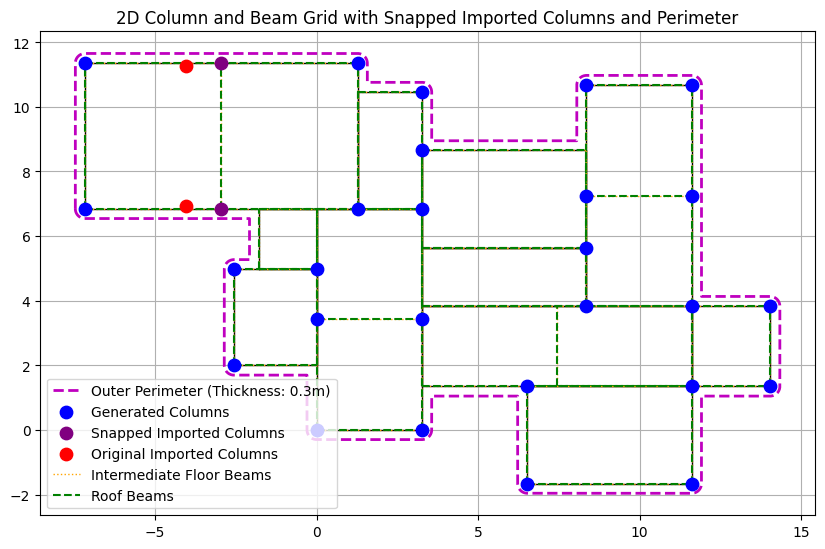

Widget(value='<iframe src="http://localhost:55784/index.html?ui=P_0x271d2b9ed50_18&reconnect=auto" class="pyvi…

In [21]:
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
# Note: Using the remembered path from your previous interactions.
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0 # Global maximum Z for the entire building footprint

wall_breps = []

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        wall_breps.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z) # Update global max_z

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# --- Section for perimeter line and wall thickness ---
while True:
    try:
        wall_thickness = float(input("Enter desired wall thickness for the perimeter (e.g., 0.3): "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for wall thickness.")

# Combine all building polygons into a single MultiPolygon
combined_building_polygon = MultiPolygon(building_volumes)

# Get the exterior boundary of the combined building and offset it
try:
    exterior_perimeter = combined_building_polygon.buffer(wall_thickness, join_style=1) # join_style=1 for mitered joints
except Exception as e:
    print(f"Could not buffer the building outline. Error: {e}")
    exterior_perimeter = None

# If the buffer operation results in a MultiPolygon, get the largest component
if exterior_perimeter and exterior_perimeter.geom_type == 'MultiPolygon':
    exterior_perimeter = max(exterior_perimeter.geoms, key=lambda p: p.area)

perimeter_line_coords = []
if exterior_perimeter:
    if exterior_perimeter.geom_type == 'Polygon':
        # Extract the exterior ring coordinates
        perimeter_line_coords = list(exterior_perimeter.exterior.coords)
    elif exterior_perimeter.geom_type == 'MultiPolygon':
        # For MultiPolygon, take the exterior of the largest polygon component
        perimeter_line_coords = list(exterior_perimeter.geoms[0].exterior.coords)
    else:
        print("Warning: The buffered perimeter is not a Polygon or MultiPolygon. Cannot extract line coordinates.")

# --- End perimeter section ---

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Plot the new perimeter line
if perimeter_line_coords:
    px_perimeter, py_perimeter = zip(*perimeter_line_coords)
    ax.plot(px_perimeter, py_perimeter, 'm--', linewidth=2, label=f'Outer Perimeter (Thickness: {wall_thickness}m)')


# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor_num in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns and Perimeter")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data):
    pt = np.array([x, y])
    closest_wall = None
    closest_dist = float('inf')

    for wall in wall_data:
        poly = wall['polygon']
        dist = poly.exterior.distance(Point(x, y))
        if dist < closest_dist:
            closest_dist = dist
            closest_wall = wall

    if closest_wall:
        return closest_wall['bbox'].Max.Z
    else:
        return max_z  # fallback to global max_z

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Define sizes for structural elements
column_radius = 0.15 # Changed from 0.1
beam_radius = 0.1   # Changed from 0.04
slab_thickness = 0.15

# Columns as vertical cylinders
for x, y in all_base_columns:
    wall_height = get_wall_height(x, y, wall_breps)
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                           radius=column_radius, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as cylinders
for (x1, y1), (x2, y2) in beams:
    h1 = get_wall_height(x1, y1, wall_breps)
    h2 = get_wall_height(x2, y2, wall_breps)
    floor_height_for_beams = min(h1, h2) # Represents the effective height for beam placement within this segment

    for floor_num in range(1, num_floors + 1): # Beams are drawn for each floor level (1 to num_floors)
        # Z for the center of the beam
        beam_z = floor_height_for_beams / num_floors * floor_num

        # Skip beams if they exceed the actual height of the wall segment
        if beam_z > h1 or beam_z > h2:
            continue

        start = np.array([x1, y1, beam_z])
        end = np.array([x2, y2, beam_z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6: # Avoid division by zero for zero-length beams
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor_num == num_floors else 'orange' # Green for roof beams, orange for intermediate
        plotter.add_mesh(beam, color=color)

# Add slabs
for room_poly, _ in detected_rooms:
    # Get the specific max Z for this room's bounding box
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0: # Fallback, though should be covered by bbox finding
        room_specific_max_z = max_z

    if num_floors > 0:
        # Calculate the height of each story for this room
        effective_story_height = room_specific_max_z / num_floors
    else:
        effective_story_height = 0 # Should not happen due to num_floors validation

    # Create slabs only for floors above ground and the roof
    # i=1 for 1st floor slab, ..., i=num_floors for roof slab
    for i in range(1, num_floors + 1): # FIX: Changed range to start from 1
        slab_base_z = i * effective_story_height

        # Adjust slab thickness for the top-most slab or if it exceeds room height
        current_slab_thickness_for_this_level = slab_thickness
        if slab_base_z + slab_thickness > room_specific_max_z + 1e-6: # Add tolerance for float comparison
            # If the full slab would extend beyond the room's defined height,
            # clamp its thickness so its top aligns with room_specific_max_z.
            current_slab_thickness_for_this_level = max(0, room_specific_max_z - slab_base_z)
            if current_slab_thickness_for_this_level < 1e-6: # Avoid drawing negligible slabs
                continue
        
        # Convert 2D shapely polygon coordinates to 3D points (X, Y, Z=0 for base plane) for PyVista
        points_3d_for_slab_base = []
        for x, y in room_poly.exterior.coords:
            points_3d_for_slab_base.append([x, y, 0.0]) # Add a Z-coordinate (0 for the base plane)
        
        points_3d_for_slab_base = np.array(points_3d_for_slab_base)

        if len(points_3d_for_slab_base) < 3: # Need at least 3 points for a polygon
            continue

        slab_base_mesh = pv.PolyData(points_3d_for_slab_base) # Pass the (N,3) array
        
        # Triangulate the 2D base polygon for extrusion
        try:
            triangulated_faces = slab_base_mesh.delaunay_2d().faces
            if triangulated_faces is None or len(triangulated_faces) == 0:
                print(f"Skipping slab due to empty triangulation for polygon {room_poly.bounds}")
                continue
            slab_base_mesh = pv.PolyData(points_3d_for_slab_base, faces=triangulated_faces) # Recreate with faces
        except Exception as e:
            print(f"Delaunay triangulation failed for a slab base ({room_poly.bounds}): {e}. Skipping slab.")
            continue

        # Extrude the triangulated base to create the 3D slab
        # The vector's Z component now directly defines the extrusion depth
        slab_mesh = slab_base_mesh.extrude(vector=(0, 0, current_slab_thickness_for_this_level), capping=True)
        slab_mesh = slab_mesh.translate((0, 0, slab_base_z)) # Move the slab to its correct Z level
        
        plotter.add_mesh(slab_mesh, color='sienna', opacity=0.8, smooth_shading=True)

# Add the perimeter line in 3D (at base level)
if perimeter_line_coords:
    # Convert 2D coordinates to 3D at Z=0 for the base perimeter
    perimeter_3d_points = [[x, y, 0] for x, y in perimeter_line_coords]
    
    # Create a PolyData object for the line segments
    lines = []
    for i in range(len(perimeter_3d_points) - 1):
        lines.extend([2, i, i + 1])
    # Close the loop (connect last point to first)
    if len(perimeter_3d_points) > 1:
        lines.extend([2, len(perimeter_3d_points) - 1, 0])

    perimeter_polydata = pv.PolyData(perimeter_3d_points, lines=lines)
    plotter.add_mesh(perimeter_polydata, color='magenta', line_width=5, render_lines_as_tubes=True, label="Outer Perimeter Line")

# Actual Brep-based walls visualization (semi-transparent)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show the 3D plot
plotter.show_grid()
plotter.show()

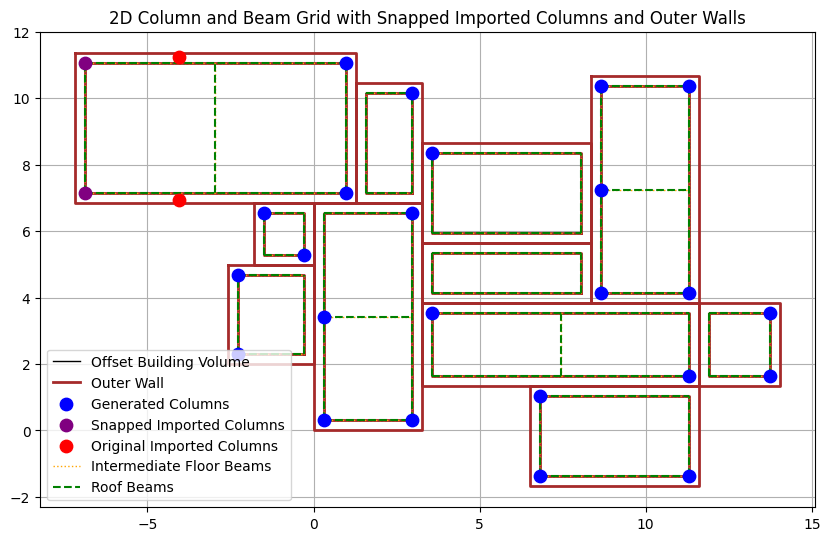

TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.

In [2]:
# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0

original_wall_breps = [] # Store original bounding box data

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        original_wall_breps.append({'polygon': poly, 'bbox': bbox}) # Store original for wall creation
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Ask for wall thickness
while True:
    try:
        wall_thickness = float(input("How thick do you want the outer wall to be (in meters, e.g., 0.3 for 30cm)? "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for the wall thickness.")

# Room sorting - Now using the offset polygons for internal logic
offset_building_volumes = []
outer_walls_polygons = []
for original_poly_data in original_wall_breps:
    original_poly = original_poly_data['polygon']
    
    # Create an inner offset for column placement
    offset_poly = original_poly.buffer(-wall_thickness)
    if not offset_poly.is_empty:
        offset_building_volumes.append(offset_poly)
        
        # Create the outer wall polygon (difference between original and offset)
        outer_wall_poly = original_poly.difference(offset_poly)
        if not outer_wall_poly.is_empty:
            outer_walls_polygons.append(outer_wall_poly)


detected_rooms = sorted([(poly, poly.area) for poly in offset_building_volumes], key=lambda x: -x[1])


# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines (offset)
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1, label='Offset Building Volume' if poly == detected_rooms[0][0] else "")

# Outer walls
for wall_poly in outer_walls_polygons:
    px, py = wall_poly.exterior.xy
    ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall' if wall_poly == outer_walls_polygons[0] else "")
    # If the outer wall is a MultiPolygon (due to complex shapes), iterate its parts
    if wall_poly.geom_type == 'MultiPolygon':
        for single_poly in wall_poly.geoms:
            px, py = single_poly.exterior.xy
            ax.plot(px, py, 'brown', linewidth=2)
            for interior_ring in single_poly.interiors:
                ix, iy = interior_ring.xy
                ax.plot(ix, iy, 'brown', linewidth=2)
    elif wall_poly.geom_type == 'Polygon':
        for interior_ring in wall_poly.interiors:
            ix, iy = interior_ring.xy
            ax.plot(ix, iy, 'brown', linewidth=2)


# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns and Outer Walls")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data):
    pt = np.array([x, y])
    closest_wall = None
    closest_dist = float('inf')

    for wall in wall_data:
        poly = wall['polygon']
        dist = poly.exterior.distance(Point(x, y))
        if dist < closest_dist:
            closest_dist = dist
            closest_wall = wall

    if closest_wall:
        return closest_wall['bbox'].Max.Z
    else:
        return max_z  # fallback


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System and Walls")

# Columns as vertical cylinders
for x, y in all_base_columns:
    wall_height = get_wall_height(x, y, original_wall_breps) # Use original height for columns
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                           radius=0.1, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04  # thinner than column radius 0.1

for (x1, y1), (x2, y2) in beams:
    h1 = get_wall_height(x1, y1, original_wall_breps) # Use original height for beams
    h2 = get_wall_height(x2, y2, original_wall_breps)
    floor_height = min(h1, h2)

    for floor in range(1, num_floors + 1):
        z = floor_height / num_floors * floor

        # Skip beams above wall height (important for cantilevers or partial-height volumes)
        if z > h1 or z > h2:
            continue

        start = np.array([x1, y1, z])
        end = np.array([x2, y2, z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)

# Add 3D representation of the outer walls
for wall_poly in outer_walls_polygons:
    # Get the height from the original building volume's bounding box
    wall_bbox = None
    for original_data in original_wall_breps:
        if original_data['polygon'].contains(wall_poly.exterior.coords[0]): # Check if the wall polygon's exterior is within the original
            wall_bbox = original_data['bbox']
            break
    
    if wall_bbox:
        wall_height = wall_bbox.Max.Z
        
        # If the outer wall is a MultiPolygon (due to complex shapes), iterate its parts
        if wall_poly.geom_type == 'MultiPolygon':
            for single_poly in wall_poly.geoms:
                for interior_ring in single_poly.interiors:
                    # Extrude the outer ring and subtract any inner rings
                    outer_coords = list(single_poly.exterior.coords)
                    outer_verts = [(p[0], p[1], 0) for p in outer_coords]
                    
                    inner_coords = list(interior_ring.coords)
                    inner_verts = [(p[0], p[1], 0) for p in inner_coords]

                    # Create a polydata for the outer boundary
                    outer_poly_pv = pv.PolyData(outer_verts).extrude((0, 0, wall_height))
                    plotter.add_mesh(outer_poly_pv, color='brown', opacity=0.7)
        elif wall_poly.geom_type == 'Polygon':
            # Extrude the outer ring and subtract any inner rings
            outer_coords = list(wall_poly.exterior.coords)
            outer_verts = [(p[0], p[1], 0) for p in outer_coords]
            
            # Create a polydata for the outer boundary
            outer_poly_pv = pv.PolyData(outer_verts).extrude((0, 0, wall_height))
            plotter.add_mesh(outer_poly_pv, color='brown', opacity=0.7)
            
            for interior_ring in wall_poly.interiors:
                inner_coords = list(interior_ring.coords)
                inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                # Create a polydata for the inner boundary (hole)
                inner_poly_pv = pv.PolyData(inner_verts).extrude((0, 0, wall_height))
                
                # Subtract the inner hole from the outer wall
                # This part is complex with pyvista for solid subtraction of extruded polygons,
                # so for simple visualization, we'll just add the outer part for now.
                # For accurate solid modeling, dedicated CAD kernels or more advanced libraries would be needed.
                # For this exercise, visual representation of the outer wall is prioritized.


# Actual Brep-based walls visualization (original building outline)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            # Add with very low opacity to show the original building envelope,
            # distinct from the new "outer walls"
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.1)

# Set up the camera and show
plotter.show_grid()
plotter.show()

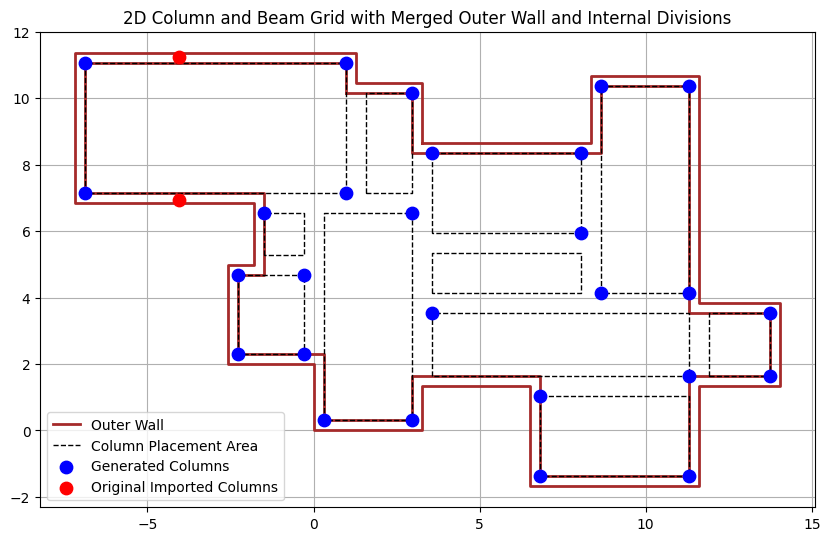

C:\Users\papad\AppData\Roaming\Python\Python313\site-packages\pyvista\core\filters\poly_data.py:3434: PyVistaFutureWarning: The default value of the ``capping`` keyword argument will change in a future version to ``True`` to match the behavior of VTK. We recommend passing the keyword explicitly to prevent future surprises.
  warnings.warn(


Widget(value='<iframe src="http://localhost:55784/index.html?ui=P_0x271d2b9f390_4&reconnect=auto" class="pyvis…

In [5]:
# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
from shapely.ops import unary_union # Import for merging polygons
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_polygons_2d_original = [] # List to store original 2D shapely Polygons for internal logic
imported_columns = []
max_z = 0.0
building_bbox_data = [] # Stores {'polygon': original_shapely_poly, 'bbox': rhino_bbox}

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_polygons_2d_original.append(poly) # Store original polygons
        building_bbox_data.append({'polygon': poly, 'bbox': bbox}) # Keep original data for height lookups
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_polygons_2d_original:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Ask for wall thickness
while True:
    try:
        wall_thickness = float(input("How thick do you want the outer wall to be (in meters, e.g., 0.3 for 30cm)? "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for the wall thickness.")

# --- Outer Wall Calculation (uses merged perimeter) ---
merged_building_outline = unary_union(building_polygons_2d_original)

temp_offset_outline_for_wall = merged_building_outline.buffer(-wall_thickness, join_style='mitre', mitre_limit=5.0)

outer_wall_merged_polygon = None
if temp_offset_outline_for_wall and not temp_offset_outline_for_wall.is_empty:
    outer_wall_merged_polygon = merged_building_outline.difference(temp_offset_outline_for_wall)
else:
    # If the inner offset for the wall is empty, the entire merged outline might be the wall
    # This scenario implies the entire footprint becomes "wall" if the offset eats it up.
    # For now, we'll assume a valid inner offset is usually possible for a non-empty building.
    print("Warning: Merged inner offset for outer wall is empty. Outer wall might be missing or cover the whole footprint.")
    # As a fallback, if offset fails, the wall could be the merged outline itself (though likely too thick)
    # outer_wall_merged_polygon = merged_building_outline # Uncomment if this fallback behavior is desired


# --- Column and Beam Placement (uses individual room divisions, offset inwards) ---
detected_rooms = []
for original_poly in building_polygons_2d_original:
    # Offset EACH original room polygon inwards for column placement
    offset_room_poly = original_poly.buffer(-wall_thickness, join_style='mitre', mitre_limit=5.0)
    if not offset_room_poly.is_empty and offset_room_poly.area > 1e-6: # Ensure it's a valid, non-tiny polygon
        # If offsetting an individual room creates a MultiPolygon (e.g., if it had an internal void)
        if offset_room_poly.geom_type == 'MultiPolygon':
            for single_poly in offset_room_poly.geoms:
                if single_poly.area > 1e-6:
                    detected_rooms.append((single_poly, single_poly.area))
        else: # It's a Polygon
            detected_rooms.append((offset_room_poly, offset_room_poly.area))

detected_rooms.sort(key=lambda x: -x[1]) # Sort by area, largest first


# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy() # This will hold ALL final column locations
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    
    # Generate potential column points on a grid within the room's bounding box
    x_points_grid = np.arange(minx, maxx + MaxS, MaxS)
    y_points_grid = np.arange(miny, maxy + MaxS, MaxS)
    
    # Ensure there's at least one point if the room is smaller than MaxS
    if len(x_points_grid) == 0: x_points_grid = np.array([(minx + maxx) / 2])
    if len(y_points_grid) == 0: y_points_grid = np.array([(miny + maxy) / 2])
    
    room_candidates = []
    for x in x_points_grid:
        for y in y_points_grid:
            p_candidate = Point(x, y)
            # Only consider points strictly inside the current room_poly
            if room_poly.contains(p_candidate):
                room_candidates.append((x, y))

    # Add points close to corners of the room_poly
    for corner_coords in room_poly.exterior.coords:
        p_corner = Point(corner_coords)
        # Ensure corners are within or very close to the boundary of the actual polygon
        if room_poly.contains(p_corner) or room_poly.boundary.distance(p_corner) < 1e-6:
            # Check against ALL existing columns (including those from other rooms or snapped)
            if all(np.linalg.norm(np.array(corner_coords) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
                columns.append(corner_coords)
                existing_columns.append(corner_coords)

    # Now process the filtered room_candidates and try to snap imported columns
    for col_candidate in room_candidates:
        snap = False
        for imp_col in available_imported:
            # Snap imported columns if close enough to a candidate point
            if np.linalg.norm(np.array(col_candidate) - np.array(imp_col)) < MinS:
                corrected_columns.append(col_candidate)
                existing_columns.append(col_candidate)
                available_imported.remove(imp_col) # Mark as used
                snap = True
                break
        # If not snapped, add as a new generated column, ensuring minimum spacing
        if not snap and all(np.linalg.norm(np.array(col_candidate) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col_candidate)
            existing_columns.append(col_candidate)

    # Beam generation logic - only connect columns found within THIS room_poly
    # We need a list of columns that are actually placed within the current room_poly
    current_room_placed_cols = [c for c in existing_columns if room_poly.contains(Point(c)) or room_poly.boundary.distance(Point(c)) < 1e-6]
    
    unique_x = sorted(list(set([c[0] for c in current_room_placed_cols])))
    unique_y = sorted(list(set([c[1] for c in current_room_placed_cols])))
    
    # Generate horizontal beams
    for y_coord in unique_y:
        cols_on_y = sorted([c for c in current_room_placed_cols if abs(c[1] - y_coord) < 1e-6], key=lambda c: c[0])
        for i in range(len(cols_on_y) - 1):
            start_col = cols_on_y[i]
            end_col = cols_on_y[i+1]
            beam_line = LineString([start_col, end_col])
            # Check if the entire beam segment is within the room_poly
            if room_poly.contains(beam_line):
                 beams.append((start_col, end_col))

    # Generate vertical beams
    for x_coord in unique_x:
        cols_on_x = sorted([c for c in current_room_placed_cols if abs(c[0] - x_coord) < 1e-6], key=lambda c: c[1])
        for i in range(len(cols_on_x) - 1):
            start_col = cols_on_x[i]
            end_col = cols_on_x[i+1]
            beam_line = LineString([start_col, end_col])
            # Check if the entire beam segment is within the room_poly
            if room_poly.contains(beam_line):
                beams.append((start_col, end_col))


# 8. 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the merged outer wall (only if successfully created)
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for poly in outer_wall_merged_polygon.geoms:
            if not poly.is_empty:
                px, py = poly.exterior.xy
                ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall' if poly == outer_wall_merged_polygon.geoms[0] else "")
                for interior_ring in poly.interiors:
                    ix, iy = interior_ring.xy
                    ax.plot(ix, iy, 'brown', linewidth=2)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            px, py = outer_wall_merged_polygon.exterior.xy
            ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall')
            for interior_ring in outer_wall_merged_polygon.interiors:
                ix, iy = interior_ring.xy
                ax.plot(ix, iy, 'brown', linewidth=2)


# Plot the individual "Column Placement Areas" (offset original rooms)
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k--', linewidth=1, label='Column Placement Area' if poly == detected_rooms[0][0] else "")
    if poly.geom_type == 'Polygon':
        for interior_ring in poly.interiors: # Plot interior rings if they exist (e.g. for donut shapes)
            ix, iy = interior_ring.xy
            ax.plot(ix, iy, 'k--', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Merged Outer Wall and Internal Divisions")
ax.grid(True)
plt.show()

# Helper to get the correct height for a given 2D point based on original building parts
def get_height_for_point(x, y, building_data_list):
    pt_shapely = Point(x, y)
    for data in building_data_list:
        # Check if point is contained within or very close to the boundary of an original building polygon
        if data['polygon'].contains(pt_shapely) or data['polygon'].exterior.distance(pt_shapely) < 1e-6:
            return data['bbox'].Max.Z
    return max_z # Fallback to max_z if point is outside all known building parts

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System and Merged Outer Wall")

# Columns as vertical cylinders
for x, y in existing_columns: # Use existing_columns as it contains all placed columns
    wall_height = get_height_for_point(x, y, building_bbox_data) # Use original height
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                           radius=0.1, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04

for (x1, y1), (x2, y2) in beams:
    h1 = get_height_for_point(x1, y1, building_bbox_data)
    h2 = get_height_for_point(x2, y2, building_bbox_data)
    floor_height = min(h1, h2) # Beams are constrained by the lowest part of the building they connect

    for floor in range(1, num_floors + 1):
        z = floor_height / num_floors * floor

        # Skip beams above wall height
        if z > h1 or z > h2:
            continue

        start = np.array([x1, y1, z])
        end = np.array([x2, y2, z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)

# Add 3D representation of the merged outer wall
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    wall_height_for_merged = max_z # Default height for the entire merged wall
    
    # Try to find a representative height from building_bbox_data for the wall
    # This is a simplification; for truly varying heights, you might need to tessellate the wall
    # and assign heights based on each segment's location.
    if building_bbox_data:
        # Get height of the largest original building footprint, as a representative
        largest_original_area = 0
        for data in building_bbox_data:
            if data['polygon'].area > largest_original_area:
                largest_original_area = data['polygon'].area
                wall_height_for_merged = data['bbox'].Max.Z
    
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for poly in outer_wall_merged_polygon.geoms:
            if not poly.is_empty:
                outer_coords = list(poly.exterior.coords)
                outer_verts = [(p[0], p[1], 0) for p in outer_coords]
                
                if outer_verts:
                    pv_mesh = pv.PolyData(outer_verts).extrude((0, 0, wall_height_for_merged))
                    plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)

                for interior_ring in poly.interiors:
                    inner_coords = list(interior_ring.coords)
                    inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                    if inner_verts:
                        pv_mesh_hole = pv.PolyData(inner_verts).extrude((0, 0, wall_height_for_merged))
                        plotter.add_mesh(pv_mesh_hole, color='brown', opacity=0.7)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            outer_coords = list(outer_wall_merged_polygon.exterior.coords)
            outer_verts = [(p[0], p[1], 0) for p in outer_coords]
            if outer_verts:
                pv_mesh = pv.PolyData(outer_verts).extrude((0, 0, wall_height_for_merged))
                plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)

            for interior_ring in outer_wall_merged_polygon.interiors:
                inner_coords = list(interior_ring.coords)
                inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                if inner_verts:
                    pv_mesh_hole = pv.PolyData(inner_verts).extrude((0, 0, wall_height_for_merged))
                    plotter.add_mesh(pv_mesh_hole, color='brown', opacity=0.7)


# Actual Brep-based walls visualization (original building outline)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.1)

# Set up the camera and show
plotter.show_grid()
plotter.show()

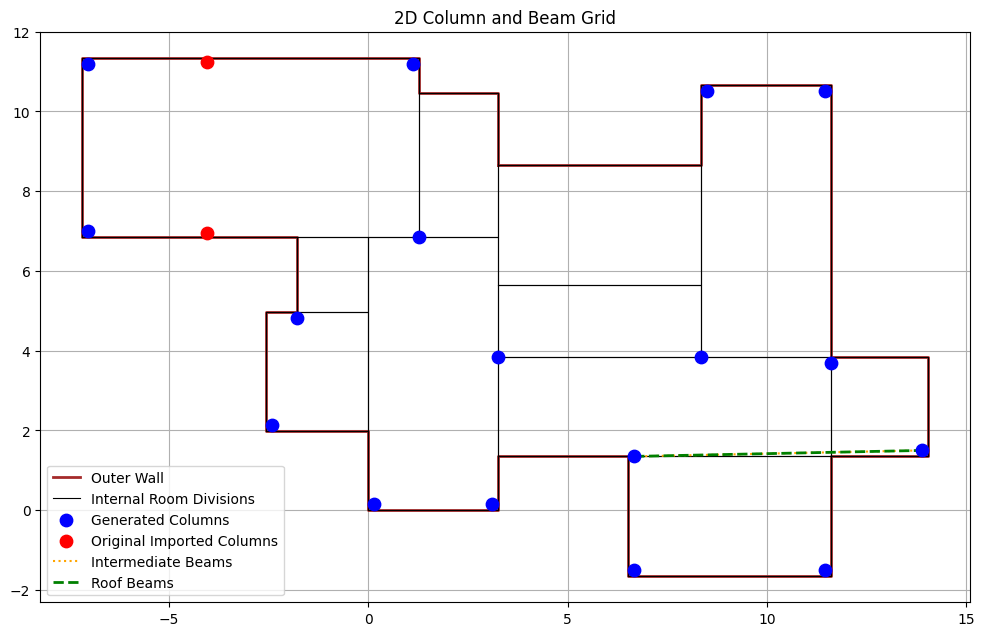

AttributeError: module 'pyvista' has no attribute 'Face'

In [14]:
# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
from shapely.ops import unary_union, nearest_points
import matplotlib.pyplot as plt
import os
import pyvista as pv

# --- File Path ---
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# --- Model Loading ---
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")
column_layer = 'columns' if 'columns' in layers else 'column'

# --- Geometry Extraction ---
building_polygons_2d_original = []
imported_columns = []
max_z = 0.0
building_bbox_data = []
for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        bbox = geom.GetBoundingBox()
        base_pts = [[bbox.Min.X, bbox.Min.Y], [bbox.Max.X, bbox.Min.Y], [bbox.Max.X, bbox.Max.Y], [bbox.Min.X, bbox.Max.Y]]
        poly = Polygon(base_pts)
        building_polygons_2d_original.append(poly)
        building_bbox_data.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z)
    elif layer_idx == layers[column_layer] and isinstance(geom, rhino3dm.Brep):
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))
if not building_polygons_2d_original:
    raise RuntimeError("No valid building geometry found.")

# --- User Inputs ---
num_floors = int(input("How many floors does the building have? (e.g., 2): "))
wall_thickness = float(input("How thick should the outer wall be (in meters, e.g., 0.3)? "))

# --- Geometric Processing ---
merged_building_outline = unary_union(building_polygons_2d_original)
inner_wall_boundary_poly = merged_building_outline.buffer(-wall_thickness, join_style='mitre', mitre_limit=5.0)
outer_wall_merged_polygon = merged_building_outline.difference(inner_wall_boundary_poly) if inner_wall_boundary_poly and not inner_wall_boundary_poly.is_empty else None
detected_rooms = sorted([(poly, poly.area) for poly in building_polygons_2d_original], key=lambda x: -x[1])

# --- Structural Logic ---
MaxS, MinS = 6.0, 3.0
columns, corrected_columns = [], []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

# 1. Generate columns and internal beams
for room_poly, _ in detected_rooms:
    # (Existing logic for placing columns and internal beams remains the same)
    minx, miny, maxx, maxy = room_poly.bounds
    x_grid = np.arange(minx, maxx + MaxS, MaxS); y_grid = np.arange(miny, maxy + MaxS, MaxS)
    room_candidates = [(x, y) for x in x_grid for y in y_grid if room_poly.contains(Point(x, y))]
    room_candidates.extend(list(room_poly.exterior.coords))
    current_room_cols = []
    for col_candidate in room_candidates:
        if any(np.linalg.norm(np.array(col_candidate) - np.array(ec)) < MinS for ec in existing_columns): continue
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col_candidate) - np.array(imp_col)) < MinS:
                corrected_columns.append(col_candidate); available_imported.remove(imp_col); snap = True; break
        if not snap: columns.append(col_candidate)
        existing_columns.append(col_candidate); current_room_cols.append(col_candidate)
    unique_x = sorted({c[0] for c in current_room_cols}); unique_y = sorted({c[1] for c in current_room_cols})
    for y in unique_y:
        cols_on_y = sorted([c for c in current_room_cols if abs(c[1] - y) < 1e-6], key=lambda c: c[0])
        for i in range(len(cols_on_y) - 1):
            if room_poly.contains(LineString([cols_on_y[i], cols_on_y[i+1]])): beams.append((cols_on_y[i], cols_on_y[i+1]))
    for x in unique_x:
        cols_on_x = sorted([c for c in current_room_cols if abs(c[0] - x) < 1e-6], key=lambda c: c[1])
        for i in range(len(cols_on_x) - 1):
            if room_poly.contains(LineString([cols_on_x[i], cols_on_x[i+1]])): beams.append((cols_on_x[i], cols_on_x[i+1]))

# 2. Add perimeter beams
perimeter_boundary = merged_building_outline.boundary
perimeter_cols = [col for col in existing_columns if perimeter_boundary.distance(Point(col)) < 1e-5]
unique_x_perim = sorted({c[0] for c in perimeter_cols}); unique_y_perim = sorted({c[1] for c in perimeter_cols})
for y in unique_y_perim:
    cols_on_y = sorted([c for c in perimeter_cols if abs(c[1] - y) < 1e-6], key=lambda c: c[0])
    for i in range(len(cols_on_y) - 1):
        start_col, end_col = cols_on_y[i], cols_on_y[i+1]
        if merged_building_outline.contains(LineString([start_col, end_col]).centroid):
            if (start_col, end_col) not in beams and (end_col, start_col) not in beams: beams.append((start_col, end_col))
for x in unique_x_perim:
    cols_on_x = sorted([c for c in perimeter_cols if abs(c[0] - x) < 1e-6], key=lambda c: c[1])
    for i in range(len(cols_on_x) - 1):
        start_col, end_col = cols_on_x[i], cols_on_x[i+1]
        if merged_building_outline.contains(LineString([start_col, end_col]).centroid):
            if (start_col, end_col) not in beams and (end_col, start_col) not in beams: beams.append((start_col, end_col))

# --- NEW: Adjust Perimeter Columns to Sit Inside Walls ---
moved_columns_map = {}
final_existing_columns = []
if inner_wall_boundary_poly and not inner_wall_boundary_poly.is_empty:
    outer_boundary = merged_building_outline.boundary
    inner_boundary = inner_wall_boundary_poly.boundary

    for col_pos in existing_columns:
        p_col = Point(col_pos)
        if outer_boundary.distance(p_col) < 1e-5:
            # This is a perimeter column. Find closest points on inner and outer wall boundaries.
            p_on_outer = nearest_points(p_col, outer_boundary)[1]
            p_on_inner = nearest_points(p_col, inner_boundary)[1]
            # Calculate the midpoint to center the column in the wall
            new_pos = ((p_on_outer.x + p_on_inner.x) / 2, (p_on_outer.y + p_on_inner.y) / 2)
            final_existing_columns.append(new_pos)
            moved_columns_map[col_pos] = new_pos
        else:
            # This is an internal column, keep its original position.
            final_existing_columns.append(col_pos)
            
    # If any columns were moved, update all lists that depend on their positions.
    if moved_columns_map:
        existing_columns = final_existing_columns
        columns = [moved_columns_map.get(c, c) for c in columns]
        corrected_columns = [moved_columns_map.get(c, c) for c in corrected_columns]
        beams = [(moved_columns_map.get(b[0], b[0]), moved_columns_map.get(b[1], b[1])) for b in beams]

# --- 2D Visualization ---
fig, ax = plt.subplots(figsize=(12, 12)); ax.set_aspect('equal', 'box'); plt.title("2D Column and Beam Grid")
if outer_wall_merged_polygon:
    if isinstance(outer_wall_merged_polygon, MultiPolygon):
        for i, p in enumerate(outer_wall_merged_polygon.geoms): ax.plot(*p.exterior.xy, 'brown', lw=2, label="Outer Wall" if i == 0 else "")
    else: ax.plot(*outer_wall_merged_polygon.exterior.xy, 'brown', lw=2, label="Outer Wall")
for i, (p, _) in enumerate(detected_rooms): ax.plot(*p.exterior.xy, 'k-', lw=0.8, label="Internal Room Divisions" if i == 0 else "")
if columns: ax.scatter(*zip(*columns), c='blue', s=80, label='Generated Columns', zorder=5)
if imported_columns: ax.scatter(*zip(*imported_columns), c='red', s=80, label='Original Imported Columns', zorder=10) # Red dots show original position
if corrected_columns: ax.scatter(*zip(*corrected_columns), c='purple', s=80, label='Placed Columns (Snapped/Moved)', zorder=7)
roof_label_added, intermediate_label_added = False, False
for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        ax.plot([x1, x2], [y1, y2], c='orange', ls=':', lw=1.5, label='Intermediate Beams' if not intermediate_label_added else ""); intermediate_label_added = True
    ax.plot([x1, x2], [y1, y2], c='green', ls='--', lw=2, label='Roof Beams' if not roof_label_added else ""); roof_label_added = True
handles, labels = ax.get_legend_handles_labels(); unique_labels = dict(zip(labels, handles)); ax.legend(unique_labels.values(), unique_labels.keys()); ax.grid(True); plt.show()

# --- 3D Visualization ---
def get_height_for_point(x, y, data_list, fallback_height):
    pt = Point(x, y)
    for data in data_list:
        if data['polygon'].contains(pt): return data['bbox'].Max.Z
    return fallback_height
plotter = pv.Plotter(title="3D Structural System")
for x, y in existing_columns:
    height = get_height_for_point(x, y, building_bbox_data, max_z)
    plotter.add_mesh(pv.Cylinder(center=(x, y, height / 2), direction=(0, 0, 1), radius=0.1, height=height), color='blue')
for (x1, y1), (x2, y2) in beams:
    h1 = get_height_for_point(x1, y1, building_bbox_data, max_z); h2 = get_height_for_point(x2, y2, building_bbox_data, max_z)
    beam_base_height = min(h1, h2)
    for floor in range(1, num_floors + 1):
        z = (beam_base_height / num_floors) * floor
        plotter.add_mesh(pv.Line([x1, y1, z], [x2, y2, z]).tube(radius=0.05), color='green' if floor == num_floors else 'orange')
if outer_wall_merged_polygon:
    wall_height = max((d['bbox'].Max.Z for d in building_bbox_data), default=max_z)
    polygons_to_extrude = outer_wall_merged_polygon.geoms if isinstance(outer_wall_merged_polygon, MultiPolygon) else [outer_wall_merged_polygon]
    for poly in polygons_to_extrude:
        if not poly.is_empty:
            exterior_pts = np.array([[*p, 0] for p in poly.exterior.coords])
            interior_holes = [np.array([[*p, 0] for p in interior.coords]) for interior in poly.interiors]
            face_with_holes = pv.Face(exterior_pts, interior_holes)
            plotter.add_mesh(face_with_holes.extrude((0, 0, wall_height), capping=True), color='brown', opacity=0.7)
plotter.add_axes(); plotter.show_grid(); plotter.show()

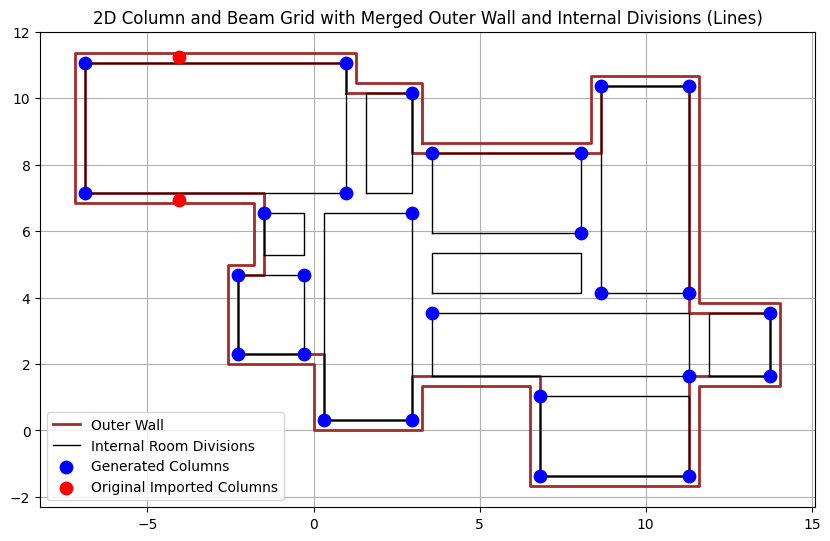

C:\Users\papad\AppData\Roaming\Python\Python313\site-packages\pyvista\core\filters\poly_data.py:3434: PyVistaFutureWarning: The default value of the ``capping`` keyword argument will change in a future version to ``True`` to match the behavior of VTK. We recommend passing the keyword explicitly to prevent future surprises.
  warnings.warn(


Widget(value='<iframe src="http://localhost:55784/index.html?ui=P_0x271d99cf390_5&reconnect=auto" class="pyvis…

In [6]:
# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
from shapely.ops import unary_union # Import for merging polygons
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
# User-provided saved information: rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
# Using the path from the conversation history, which is also in the provided code:
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_polygons_2d_original = [] # List to store original 2D shapely Polygons for internal logic
imported_columns = []
max_z = 0.0
building_bbox_data = [] # Stores {'polygon': original_shapely_poly, 'bbox': rhino_bbox}

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_polygons_2d_original.append(poly) # Store original polygons
        building_bbox_data.append({'polygon': poly, 'bbox': bbox}) # Keep original data for height lookups
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_polygons_2d_original:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Ask for wall thickness
while True:
    try:
        wall_thickness = float(input("How thick do you want the outer wall to be (in meters, e.g., 0.3 for 30cm)? "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for the wall thickness.")

# --- Outer Wall Calculation (uses merged perimeter) ---
merged_building_outline = unary_union(building_polygons_2d_original)

temp_offset_outline_for_wall = merged_building_outline.buffer(-wall_thickness, join_style='mitre', mitre_limit=5.0)

outer_wall_merged_polygon = None
if temp_offset_outline_for_wall and not temp_offset_outline_for_wall.is_empty:
    outer_wall_merged_polygon = merged_building_outline.difference(temp_offset_outline_for_wall)
else:
    print("Warning: Merged inner offset for outer wall is empty. Outer wall might be missing or cover the whole footprint.")


# --- Column and Beam Placement (uses individual room divisions, offset inwards) ---
# This list will store the *offset polygons* that define the areas where columns/beams are placed.
# These polygons themselves are not "walls", but define the space for the structure.
detected_rooms = []
for original_poly in building_polygons_2d_original:
    # Offset EACH original room polygon inwards for column placement
    offset_room_poly = original_poly.buffer(-wall_thickness, join_style='mitre', mitre_limit=5.0)
    if not offset_room_poly.is_empty and offset_room_poly.area > 1e-6: # Ensure it's a valid, non-tiny polygon
        # If offsetting an individual room creates a MultiPolygon (e.g., if it had an internal void)
        if offset_room_poly.geom_type == 'MultiPolygon':
            for single_poly in offset_room_poly.geoms:
                if single_poly.area > 1e-6:
                    detected_rooms.append((single_poly, single_poly.area))
        else: # It's a Polygon
            detected_rooms.append((offset_room_poly, offset_room_poly.area))

detected_rooms.sort(key=lambda x: -x[1]) # Sort by area, largest first


# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy() # This will hold ALL final column locations
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    
    # Generate potential column points on a grid within the room's bounding box
    x_points_grid = np.arange(minx, maxx + MaxS, MaxS)
    y_points_grid = np.arange(miny, maxy + MaxS, MaxS)
    
    # Ensure there's at least one point if the room is smaller than MaxS
    if len(x_points_grid) == 0: x_points_grid = np.array([(minx + maxx) / 2])
    if len(y_points_grid) == 0: y_points_grid = np.array([(miny + maxy) / 2])
    
    room_candidates = []
    for x in x_points_grid:
        for y in y_points_grid:
            p_candidate = Point(x, y)
            # Only consider points strictly inside the current room_poly
            if room_poly.contains(p_candidate):
                room_candidates.append((x, y))

    # Add points close to corners of the room_poly
    for corner_coords in room_poly.exterior.coords:
        p_corner = Point(corner_coords)
        # Ensure corners are within or very close to the boundary of the actual polygon
        if room_poly.contains(p_corner) or room_poly.boundary.distance(p_corner) < 1e-6:
            # Check against ALL existing columns (including those from other rooms or snapped)
            if all(np.linalg.norm(np.array(corner_coords) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
                columns.append(corner_coords)
                existing_columns.append(corner_coords)

    # Now process the filtered room_candidates and try to snap imported columns
    for col_candidate in room_candidates:
        snap = False
        for imp_col in available_imported:
            # Snap imported columns if close enough to a candidate point
            if np.linalg.norm(np.array(col_candidate) - np.array(imp_col)) < MinS:
                corrected_columns.append(col_candidate)
                existing_columns.append(col_candidate)
                available_imported.remove(imp_col) # Mark as used
                snap = True
                break
        # If not snapped, add as a new generated column, ensuring minimum spacing
        if not snap and all(np.linalg.norm(np.array(col_candidate) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col_candidate)
            existing_columns.append(col_candidate)

    # Beam generation logic - only connect columns found within THIS room_poly
    current_room_placed_cols = [c for c in existing_columns if room_poly.contains(Point(c)) or room_poly.boundary.distance(Point(c)) < 1e-6]
    
    unique_x = sorted(list(set([c[0] for c in current_room_placed_cols])))
    unique_y = sorted(list(set([c[1] for c in current_room_placed_cols])))
    
    # Generate horizontal beams
    for y_coord in unique_y:
        cols_on_y = sorted([c for c in current_room_placed_cols if abs(c[1] - y_coord) < 1e-6], key=lambda c: c[0])
        for i in range(len(cols_on_y) - 1):
            start_col = cols_on_y[i]
            end_col = cols_on_y[i+1]
            beam_line = LineString([start_col, end_col])
            # Check if the entire beam segment is within the room_poly
            if room_poly.contains(beam_line):
                 beams.append((start_col, end_col))

    # Generate vertical beams
    for x_coord in unique_x:
        cols_on_x = sorted([c for c in current_room_placed_cols if abs(c[0] - x_coord) < 1e-6], key=lambda c: c[1])
        for i in range(len(cols_on_x) - 1):
            start_col = cols_on_x[i]
            end_col = cols_on_x[i+1]
            beam_line = LineString([start_col, end_col])
            # Check if the entire beam segment is within the room_poly
            if room_poly.contains(beam_line):
                beams.append((start_col, end_col))


# 8. 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the merged outer wall (only if successfully created)
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for poly in outer_wall_merged_polygon.geoms:
            if not poly.is_empty:
                px, py = poly.exterior.xy
                ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall' if poly == outer_wall_merged_polygon.geoms[0] else "")
                for interior_ring in poly.interiors:
                    ix, iy = interior_ring.xy
                    ax.plot(ix, iy, 'brown', linewidth=2)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            px, py = outer_wall_merged_polygon.exterior.xy
            ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall')
            for interior_ring in outer_wall_merged_polygon.interiors:
                ix, iy = interior_ring.xy
                ax.plot(ix, iy, 'brown', linewidth=2)


# Plot the individual "Column Placement Areas" as thin lines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    # Changed from 'k--' (dashed) to 'k-' (solid) for a more "room outline" feel, thickness 1
    ax.plot(px, py, 'k-', linewidth=1, label='Internal Room Divisions' if poly == detected_rooms[0][0] else "")
    if poly.geom_type == 'Polygon':
        for interior_ring in poly.interiors: # Plot interior rings if they exist (e.g. for donut shapes)
            ix, iy = interior_ring.xy
            ax.plot(ix, iy, 'k-', linewidth=1) # Consistent styling for internal rings


# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
# Update legend to reflect new label for internal divisions
handles, labels = ax.get_legend_handles_labels()
# Filter out duplicate labels for a cleaner legend
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys())

plt.title("2D Column and Beam Grid with Merged Outer Wall and Internal Divisions (Lines)")
ax.grid(True)
plt.show()

# Helper to get the correct height for a given 2D point based on original building parts
def get_height_for_point(x, y, building_data_list):
    pt_shapely = Point(x, y)
    for data in building_data_list:
        # Check if point is contained within or very close to the boundary of an original building polygon
        if data['polygon'].contains(pt_shapely) or data['polygon'].exterior.distance(pt_shapely) < 1e-6:
            return data['bbox'].Max.Z
    return max_z # Fallback to max_z if point is outside all known building parts

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System and Merged Outer Wall")

# Columns as vertical cylinders
for x, y in existing_columns: # Use existing_columns as it contains all placed columns
    wall_height = get_height_for_point(x, y, building_bbox_data) # Use original height
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                           radius=0.1, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04

for (x1, y1), (x2, y2) in beams:
    h1 = get_height_for_point(x1, y1, building_bbox_data)
    h2 = get_height_for_point(x2, y2, building_bbox_data)
    floor_height = min(h1, h2) # Beams are constrained by the lowest part of the building they connect

    for floor in range(1, num_floors + 1):
        z = floor_height / num_floors * floor

        # Skip beams above wall height
        if z > h1 or z > h2:
            continue

        start = np.array([x1, y1, z])
        end = np.array([x2, y2, z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)

# Add 3D representation of the merged outer wall
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    wall_height_for_merged = max_z # Default height for the entire merged wall
    
    # Try to find a representative height from building_bbox_data for the wall
    if building_bbox_data:
        largest_original_area = 0
        for data in building_bbox_data:
            if data['polygon'].area > largest_original_area:
                largest_original_area = data['polygon'].area
                wall_height_for_merged = data['bbox'].Max.Z
    
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for poly in outer_wall_merged_polygon.geoms:
            if not poly.is_empty:
                outer_coords = list(poly.exterior.coords)
                outer_verts = [(p[0], p[1], 0) for p in outer_coords]
                
                if outer_verts:
                    pv_mesh = pv.PolyData(outer_verts).extrude((0, 0, wall_height_for_merged))
                    plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)

                for interior_ring in poly.interiors:
                    inner_coords = list(interior_ring.coords)
                    inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                    if inner_verts:
                        pv_mesh_hole = pv.PolyData(inner_verts).extrude((0, 0, wall_height_for_merged))
                        plotter.add_mesh(pv_mesh_hole, color='brown', opacity=0.7)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            outer_coords = list(outer_wall_merged_polygon.exterior.coords)
            outer_verts = [(p[0], p[1], 0) for p in outer_coords]
            if outer_verts:
                pv_mesh = pv.PolyData(outer_verts).extrude((0, 0, wall_height_for_merged))
                plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)

            for interior_ring in outer_wall_merged_polygon.interiors:
                inner_coords = list(interior_ring.coords)
                inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                if inner_verts:
                    pv_mesh_hole = pv.PolyData(inner_verts).extrude((0, 0, wall_height_for_merged))
                    plotter.add_mesh(pv_mesh_hole, color='brown', opacity=0.7)


# Actual Brep-based walls visualization (original building outline)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.1)

# Set up the camera and show
plotter.show_grid()
plotter.show()

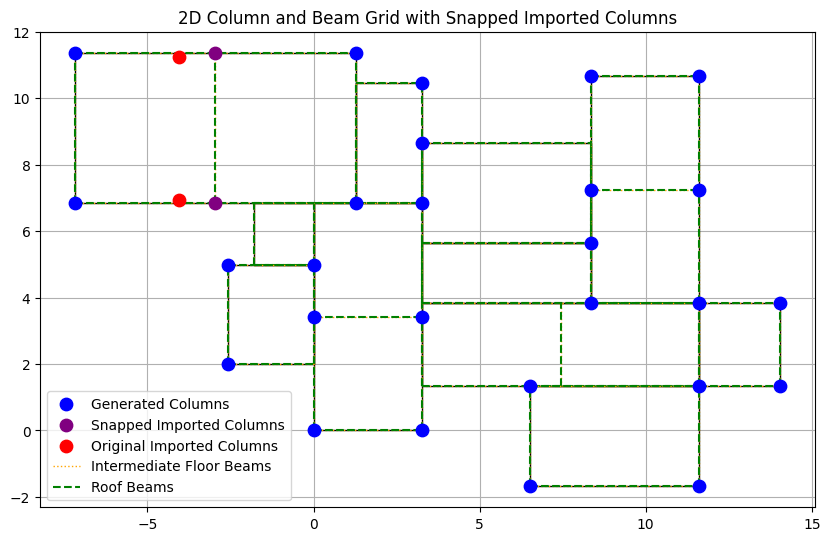

Widget(value='<iframe src="http://localhost:50772/index.html?ui=P_0x1e2a51d2fd0_1&reconnect=auto" class="pyvis…

In [2]:
 # DONT TOUCH correct

# 2. Imports
import rhino3dm 
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0
min_z_global = float('inf') # Initialize global min_z 

wall_breps = []

from shapely.geometry import Polygon
from shapely.ops import unary_union

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area)

    return None

room_brep_map = {}   # Add this before your main for-loop over model.Objects

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly)
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom})
            max_z = max(max_z, bbox.Max.Z)
            min_z_global = min(min_z_global, bbox.Min.Z) # Update global min_z 
            room_brep_map[poly.wkt] = geom 


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2 # Corrected typo: bbox.Max.Y instead of bbox.Y
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy), room_poly))   # Add room info
    for y in y_points:
        beams.append(((minx, y), (maxx, y), room_poly))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)


# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2), _ in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):   # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                            label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                    label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data, search_radius=0.5):
    max_height = 0.0
    query_point = np.array([x, y])

    for wall in wall_data:
        brep = wall['brep']

        # Get the mesh from the Brep to find the actual Z values
        # We need to iterate through all faces and their vertices to find the highest Z
        # that is close to the given (x,y) point.
        all_meshes = []
        for face in brep.Faces:
            mesh = face.GetMesh(rhino3dm.MeshType.Render)
            if mesh:
                all_meshes.append(mesh)
        
        for mesh in all_meshes:
            for i in range(len(mesh.Vertices)):
                v = mesh.Vertices[i]
                vx, vy, vz = v.X, v.Y, v.Z
                dist = np.linalg.norm(query_point - np.array([vx, vy]))
                if dist < search_radius:
                    max_height = max(max_height, vz)

    # Fallback: if nothing found within radius, use bounding box max
    # This fallback might be problematic for sloped roofs if it always returns the highest point
    # of the bbox, rather than the actual roof height at (x,y).
    # For a more robust solution, a raycast from (x,y) upwards to hit the roof mesh would be ideal,
    # but that's more complex with rhino3dm. For now, we rely on the vertex search and bbox as a last resort.
    if max_height == 0.0:
        for wall in wall_data:
            poly = wall['polygon']
            # Check if the point (x,y) is within the horizontal projection of the wall
            if Point(x, y).within(poly.buffer(search_radius)): # Use buffer to give some tolerance
                return wall['bbox'].Max.Z # This is the highest point of the bbox, not necessarily the point on the roof
        return max_z # Global max Z as ultimate fallback


    return max_height


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    # Get the wall height at the column's location (which is the roof height)
    column_top_z = get_wall_height(x, y, wall_breps)
    
    # Column height goes from global min_z to the roof height at its location
    column_height = column_top_z - min_z_global
    column_center_z = min_z_global + column_height / 2

    # Ensure column height is positive
    if column_height > 0.01: # Small threshold to avoid tiny/negative cylinders
        cylinder = pv.Cylinder(center=(x, y, column_center_z), direction=(0, 0, 1),
                                radius=0.1, height=column_height)
        plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04   # thinner than column radius 0.1

for (x1, y1), (x2, y2), poly in beams:
    brep = room_brep_map.get(poly.wkt) # Corrected typo here!
    if not brep:
        continue   # Skip if this room has no brep

    room_bbox = brep.GetBoundingBox() 
    room_min_z = room_bbox.Min.Z 
    room_max_z = room_bbox.Max.Z 

    # Calculate floor height for intermediate floors based on the room's bounding box height
    # We now calculate the height of the bounding box of the room, not the global max_z
    room_total_height = room_max_z - room_min_z
    
    # Avoid division by zero if num_floors is 1
    floor_height_interval = room_total_height / num_floors if num_floors > 0 else 0


    for floor in range(1, num_floors + 1):
        # Local wall data for getting specific roof height at beam's x,y coordinates
        local_wall_data = [{'polygon': poly, 'brep': brep, 'bbox': room_bbox}]

        if floor == num_floors:
            # For the top floor, keep the sloped roof
            z1_intended = get_wall_height(x1, y1, local_wall_data)
            z2_intended = get_wall_height(x2, y2, local_wall_data)
        else:
            # For intermediate floors, calculate based on bounding box, but clip to roof
            z_floor_level = room_min_z + floor * floor_height_interval
            
            # Get the actual roof height at beam's x,y coordinates
            roof_height_at_p1 = get_wall_height(x1, y1, local_wall_data)
            roof_height_at_p2 = get_wall_height(x2, y2, local_wall_data)

            # The beam's z should be the minimum of the calculated floor level and the roof height
            z1_intended = min(z_floor_level, roof_height_at_p1)
            z2_intended = min(z_floor_level, roof_height_at_p2)

        # Only draw the beam if it's below or at the roof height at both ends
        if z1_intended <= get_wall_height(x1, y1, local_wall_data) and z2_intended <= get_wall_height(x2, y2, local_wall_data):
            start = np.array([x1, y1, z1_intended])
            end = np.array([x2, y2, z2_intended])

            direction = end - start
            length = np.linalg.norm(direction)
            if length < 1e-6:
                continue
            direction = direction / length
            center = (start + end) / 2

            beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

            color = 'green' if floor == num_floors else 'orange'
            plotter.add_mesh(beam, color=color)


# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

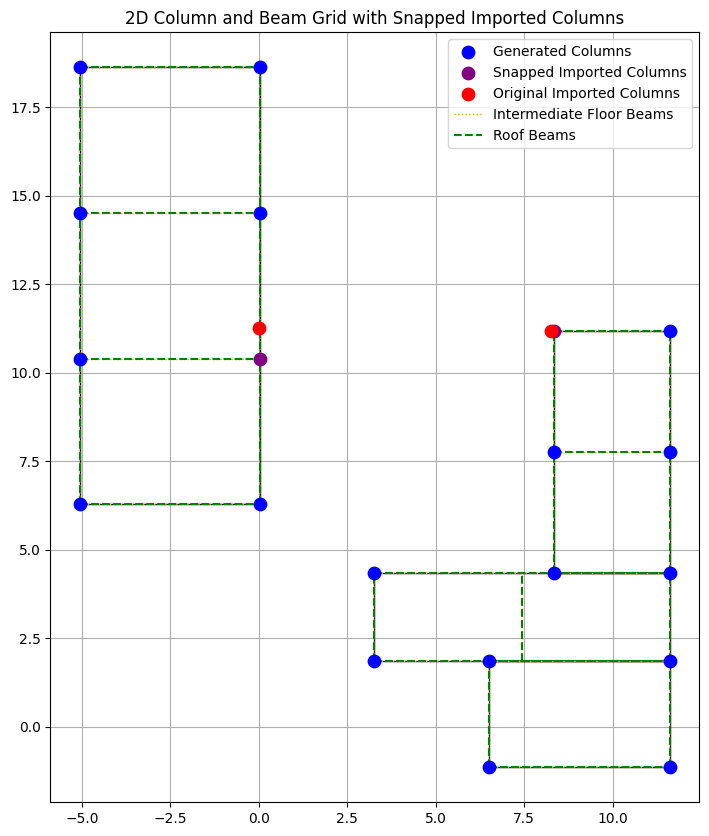

Widget(value='<iframe src="http://localhost:53674/index.html?ui=P_0x1849a1ba210_1&reconnect=auto" class="pyvis…

In [2]:
 # DONT TOUCH correct

# 2. Imports
import rhino3dm 
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0
min_z_global = float('inf') # Initialize global min_z 

wall_breps = []

from shapely.geometry import Polygon
from shapely.ops import unary_union

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area)

    return None

room_brep_map = {}   # Add this before your main for-loop over model.Objects

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly)
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom})
            max_z = max(max_z, bbox.Max.Z)
            min_z_global = min(min_z_global, bbox.Min.Z) # Update global min_z 
            room_brep_map[poly.wkt] = geom 


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2 # Corrected typo: bbox.Max.Y instead of bbox.Y
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy), room_poly))   # Add room info
    for y in y_points:
        beams.append(((minx, y), (maxx, y), room_poly))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)


# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2), _ in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):   # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                            label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                    label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data, search_radius=0.5):
    max_height = 0.0
    query_point = np.array([x, y])

    for wall in wall_data:
        brep = wall['brep']

        # Get the mesh from the Brep to find the actual Z values
        # We need to iterate through all faces and their vertices to find the highest Z
        # that is close to the given (x,y) point.
        all_meshes = []
        for face in brep.Faces:
            mesh = face.GetMesh(rhino3dm.MeshType.Render)
            if mesh:
                all_meshes.append(mesh)
        
        for mesh in all_meshes:
            for i in range(len(mesh.Vertices)):
                v = mesh.Vertices[i]
                vx, vy, vz = v.X, v.Y, v.Z
                dist = np.linalg.norm(query_point - np.array([vx, vy]))
                if dist < search_radius:
                    max_height = max(max_height, vz)

    # Fallback: if nothing found within radius, use bounding box max
    # This fallback might be problematic for sloped roofs if it always returns the highest point
    # of the bbox, rather than the actual roof height at (x,y).
    # For a more robust solution, a raycast from (x,y) upwards to hit the roof mesh would be ideal,
    # but that's more complex with rhino3dm. For now, we rely on the vertex search and bbox as a last resort.
    if max_height == 0.0:
        for wall in wall_data:
            poly = wall['polygon']
            # Check if the point (x,y) is within the horizontal projection of the wall
            if Point(x, y).within(poly.buffer(search_radius)): # Use buffer to give some tolerance
                return wall['bbox'].Max.Z # This is the highest point of the bbox, not necessarily the point on the roof
        return max_z # Global max Z as ultimate fallback


    return max_height


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    # Get the wall height at the column's location (which is the roof height)
    column_top_z = get_wall_height(x, y, wall_breps)
    
    # Column height goes from global min_z to the roof height at its location
    column_height = column_top_z - min_z_global
    column_center_z = min_z_global + column_height / 2

    # Ensure column height is positive
    if column_height > 0.01: # Small threshold to avoid tiny/negative cylinders
        cylinder = pv.Cylinder(center=(x, y, column_center_z), direction=(0, 0, 1),
                                radius=0.1, height=column_height)
        plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04   # thinner than column radius 0.1

for (x1, y1), (x2, y2), poly in beams:
    brep = room_brep_map.get(poly.wkt) # Corrected typo here!
    if not brep:
        continue   # Skip if this room has no brep

    room_bbox = brep.GetBoundingBox() 
    room_min_z = room_bbox.Min.Z 
    room_max_z = room_bbox.Max.Z 

    # Calculate floor height for intermediate floors based on the room's bounding box height
    # We now calculate the height of the bounding box of the room, not the global max_z
    room_total_height = room_max_z - room_min_z
    
    # Avoid division by zero if num_floors is 1
    floor_height_interval = room_total_height / num_floors if num_floors > 0 else 0


    for floor in range(1, num_floors + 1):
        # Local wall data for getting specific roof height at beam's x,y coordinates
        local_wall_data = [{'polygon': poly, 'brep': brep, 'bbox': room_bbox}]

        if floor == num_floors:
            # For the top floor, keep the sloped roof
            z1_intended = get_wall_height(x1, y1, local_wall_data)
            z2_intended = get_wall_height(x2, y2, local_wall_data)
        else:
            # For intermediate floors, calculate based on bounding box, but clip to roof
            z_floor_level = room_min_z + floor * floor_height_interval
            
            # Get the actual roof height at beam's x,y coordinates
            roof_height_at_p1 = get_wall_height(x1, y1, local_wall_data)
            roof_height_at_p2 = get_wall_height(x2, y2, local_wall_data)

            # The beam's z should be the minimum of the calculated floor level and the roof height
            z1_intended = min(z_floor_level, roof_height_at_p1)
            z2_intended = min(z_floor_level, roof_height_at_p2)

        # Only draw the beam if it's below or at the roof height at both ends
        if z1_intended <= get_wall_height(x1, y1, local_wall_data) and z2_intended <= get_wall_height(x2, y2, local_wall_data):
            start = np.array([x1, y1, z1_intended])
            end = np.array([x2, y2, z2_intended])

            direction = end - start
            length = np.linalg.norm(direction)
            if length < 1e-6:
                continue
            direction = direction / length
            center = (start + end) / 2

            beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

            color = 'green' if floor == num_floors else 'orange'
            plotter.add_mesh(beam, color=color)


# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

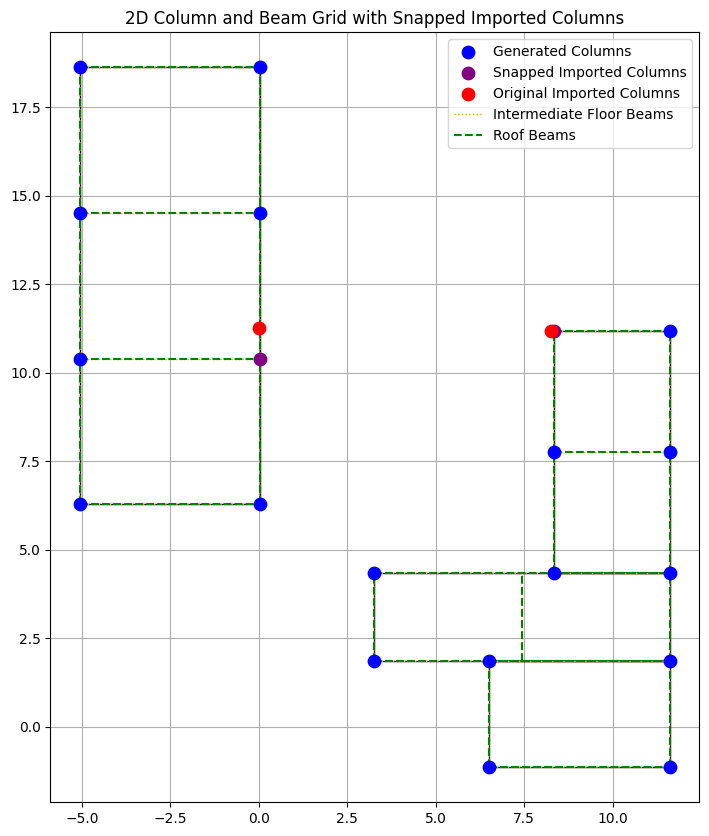

Widget(value='<iframe src="http://localhost:61263/index.html?ui=P_0x2b991ce1a90_11&reconnect=auto" class="pyvi…

In [15]:
# DONT TOUCH!!!

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0
min_z_global = float('inf') # Initialize global min_z

wall_breps = []

from shapely.geometry import Polygon
from shapely.ops import unary_union

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area)

    return None

room_brep_map = {}   # Add this before your main for-loop over model.Objects

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly)
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom})
            max_z = max(max_z, bbox.Max.Z)
            min_z_global = min(min_z_global, bbox.Min.Z) # Update global min_z
            room_brep_map[poly.wkt] = geom 


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy), room_poly))   # Add room info
    for y in y_points:
        beams.append(((minx, y), (maxx, y), room_poly))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)


# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2), _ in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):   # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                            label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                    label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data, search_radius=0.5):
    max_height = 0.0
    query_point = np.array([x, y])

    for wall in wall_data:
        brep = wall['brep']

        for face in brep.Faces:
            mesh = face.GetMesh(rhino3dm.MeshType.Render)
            if not mesh:
                continue

            for i in range(len(mesh.Vertices)):
                v = mesh.Vertices[i]
                vx, vy, vz = v.X, v.Y, v.Z
                dist = np.linalg.norm(query_point - np.array([vx, vy]))
                if dist < search_radius:
                    max_height = max(max_height, vz)

    # Fallback: if nothing found within radius, use bounding box max
    if max_height == 0.0:
        for wall in wall_data:
            poly = wall['polygon']
            dist = poly.exterior.distance(Point(x, y))
            if dist < search_radius:
                return wall['bbox'].Max.Z
        return max_z

    return max_height


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    # Use the global min_z for the column base, and wall_height for the top
    wall_height = get_wall_height(x, y, wall_breps)
    column_height = wall_height - min_z_global
    column_center_z = min_z_global + column_height / 2
    cylinder = pv.Cylinder(center=(x, y, column_center_z), direction=(0, 0, 1),
                            radius=0.1, height=column_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04   # thinner than column radius 0.1

for (x1, y1), (x2, y2), poly in beams:
    brep = room_brep_map.get(poly.wkt)
    if not brep:
        continue   # Skip if this room has no brep

    # Get the bounding box for the current room's BREP
    room_bbox = brep.GetBoundingBox()
    room_min_z = room_bbox.Min.Z
    room_max_z = room_bbox.Max.Z

    # Calculate floor height for intermediate floors based on the room's bounding box height
    floor_height_interval = (room_max_z - room_min_z) / num_floors


    for floor in range(1, num_floors + 1):
        if floor == num_floors:
            # For the top floor, keep the sloped roof
            local_wall_data = [{'polygon': poly, 'brep': brep, 'bbox': room_bbox}]
            z1 = get_wall_height(x1, y1, local_wall_data)
            z2 = get_wall_height(x2, y2, local_wall_data)
        else:
            # For intermediate floors, use the bounding box min Z and divide the total height
            z1 = z2 = room_min_z + floor * floor_height_interval

        start = np.array([x1, y1, z1])
        end = np.array([x2, y2, z2])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2

        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)


# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

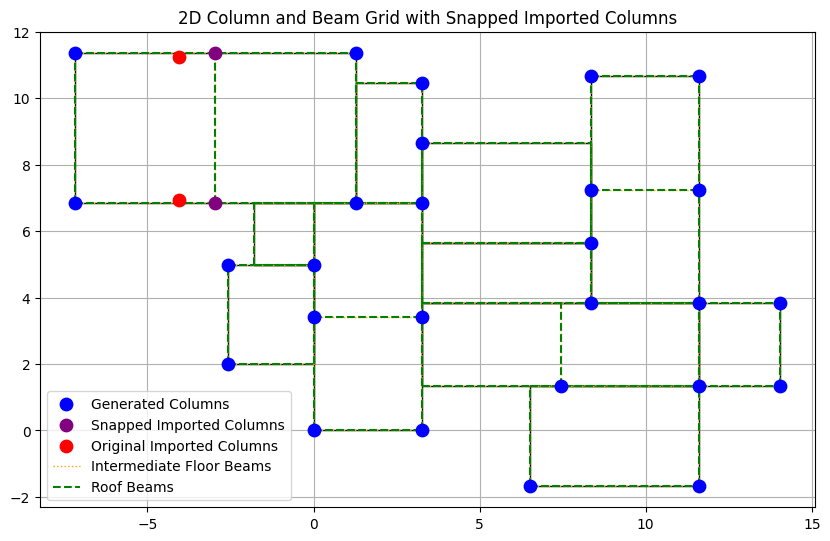

Widget(value='<iframe src="http://localhost:61263/index.html?ui=P_0x2ba0907c050_9&reconnect=auto" class="pyvis…

In [13]:
# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
# Using the path you specified in your prompt for this specific problem
# [2025-06-09] User saved preference: rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
# However, for this specific problem, the prompt specifies:
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
if model is None:
    raise RuntimeError(f"Could not read Rhino model from {rhino_path}. It might be corrupted or an invalid file.")

layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = [] # Stores (shapely.Polygon, rhino3dm.Brep, bbox) for all building parts
imported_columns = []
max_z = 0.0
min_z_global = float('inf') # Initialize global min_z

# wall_breps will now store (polygon, bbox, brep) for all building parts
wall_breps = []

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area) # Return the largest polygon from MultiPolygon
        else:
            return None # Handle other unexpected geometry types
    return None

# room_brep_map will map the WKT of the polygon to the original BREP and its bbox
room_brep_info_map = {}

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly) # Only store the polygon here for now
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom}) # Store full info for height lookup
            max_z = max(max_z, bbox.Max.Z)
            min_z_global = min(min_z_global, bbox.Min.Z)
            room_brep_info_map[poly.wkt] = {'brep': geom, 'bbox': bbox} # Store brep and bbox

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting (by area, largest first)
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    # Use the specific room_poly for generating beams within its bounds
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    
    # Ensure divisions are at least 1 to avoid issues with very small rooms
    divisions_x = max(1, int(np.ceil(width / MaxS)))
    divisions_y = max(1, int(np.ceil(height / MaxS)))
    
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        # Check if the candidate column is inside the current room_poly
        if not Point(col).within(room_poly.buffer(0.01)): # Small buffer for floating point inaccuracies
            continue

        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                if col not in existing_columns:
                    existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap:
            if all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
                columns.append(col)
                existing_columns.append(col)

    for x in x_points:
        start_point = (x, miny)
        end_point = (x, maxy)
        # Ensure the beam segment is actually within the current room_poly
        if LineString([start_point, end_point]).intersects(room_poly):
             beams.append((start_point, end_point, room_poly))
    for y in y_points:
        start_point = (minx, y)
        end_point = (maxx, y)
        if LineString([start_point, end_point]).intersects(room_poly):
            beams.append((start_point, end_point, room_poly))

    # Add corner columns if they are not too close to existing ones
    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)


# Combine all base columns
all_base_columns = columns + corrected_columns

# 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns (those not snapped)
remaining_imported_columns = [col for col in imported_columns if col not in corrected_columns]
if remaining_imported_columns:
    ix, iy = zip(*remaining_imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2), _ in beams: # The _ is a placeholder for the room_poly from `beams` list, not used here for plotting 2D.
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                                     label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                                 label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data, search_radius=0.5):
    """
    Finds the maximum Z-coordinate (height) of a wall mesh vertex within a given
    search radius of the (x,y) query point.
    Falls back to bounding box Max.Z if no mesh vertex is found nearby,
    and then to global max_z.
    """
    max_height = 0.0
    query_point_2d = np.array([x, y])

    for wall in wall_data:
        brep = wall['brep']
        all_meshes = []
        for face in brep.Faces:
            try: # Add try-except for mesh generation
                mesh = face.GetMesh(rhino3dm.MeshType.Render)
                if mesh:
                    all_meshes.append(mesh)
            except Exception as e:
                # print(f"Warning: Could not get mesh for face. Error: {e}")
                continue # Skip to the next face if meshing fails

        for mesh in all_meshes:
            for i in range(len(mesh.Vertices)):
                v = mesh.Vertices[i]
                vx, vy, vz = v.X, v.Y, v.Z
                dist = np.linalg.norm(query_point_2d - np.array([vx, vy]))
                if dist < search_radius:
                    max_height = max(max_height, vz)

    # If no mesh vertex was found, use the bounding box Max.Z if the point is within the 2D polygon
    if max_height == 0.0:
        for wall in wall_data:
            poly = wall['polygon']
            if Point(x, y).within(poly.buffer(search_radius)):
                return wall['bbox'].Max.Z
        # If no wall contains the point, return the global max Z
        return max_z

    return max_height


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    # Get the wall height at the column's location (which is the roof height)
    # The get_wall_height function will try to find a relevant wall in wall_breps
    column_top_z = get_wall_height(x, y, wall_breps)

    # Column height goes from global min_z to the roof height at its location
    column_height = column_top_z - min_z_global
    column_center_z = min_z_global + column_height / 2

    # Ensure column height is positive and reasonable
    if column_height > 0.1: # Small threshold to avoid tiny/negative cylinders (e.g., 10cm minimum height)
        cylinder = pv.Cylinder(center=(x, y, column_center_z), direction=(0, 0, 1),
                                 radius=0.1, height=column_height)
        plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04

# Calculate a typical floor height based on the overall building
# This helps ensure consistent floor spacing across different volumes
if num_floors > 0:
    typical_floor_height = (max_z - min_z_global) / num_floors
else:
    typical_floor_height = 0 # Handle case of 0 floors

for (x1, y1), (x2, y2), beam_defining_poly in beams:
    # Get the brep and bbox information for the specific polygon this beam is associated with
    room_info = room_brep_info_map.get(beam_defining_poly.wkt)
    if not room_info:
        continue # Should not happen if room_brep_info_map is populated correctly

    brep = room_info['brep']
    room_bbox = room_info['bbox']
    room_min_z = room_bbox.Min.Z # The specific room's minimum Z (its "ground" or "levitating" floor)
    room_max_z = room_bbox.Max.Z # The specific room's maximum Z (its roof)

    # Use a small buffer for intersection checks to account for floating point inaccuracies
    beam_line = LineString([(x1, y1), (x2, y2)])
    if not beam_line.intersects(beam_defining_poly.buffer(0.01)):
        continue # Skip if the beam segment falls outside its defined polygon

    # Iterate from 0 (base floor) up to num_floors (roof)
    for floor_idx in range(num_floors + 1):
        # NEW: Skip drawing a base beam if the room's minimum Z is approximately at the global ground level
        if floor_idx == 0 and abs(room_min_z - min_z_global) < 0.01: # Check if room is at global ground level (with tolerance)
            continue # Skip drawing a base beam for ground-level rooms
        
        if floor_idx == 0:
            # This is the base floor of the room (only for non-ground level rooms due to the check above)
            z_current_level = room_min_z
        else:
            # Intermediate or roof floor
            z_current_level = room_min_z + (floor_idx * typical_floor_height)

        # Get the actual roof heights at the beam's endpoints for clipping
        # Pass only the relevant wall data for this specific room
        roof_height_at_p1 = get_wall_height(x1, y1, [{'polygon': beam_defining_poly, 'brep': brep, 'bbox': room_bbox}])
        roof_height_at_p2 = get_wall_height(x2, y2, [{'polygon': beam_defining_poly, 'brep': brep, 'bbox': room_bbox}]) # Corrected this line

        # The beam's Z should be capped by the actual roof height of its associated room
        z1_intended = min(z_current_level, roof_height_at_p1)
        z2_intended = min(z_current_level, roof_height_at_p2)

        # Ensure the beam is within the vertical bounds of its associated room
        # Add a small tolerance to avoid floating point issues
        if z1_intended < room_min_z - 0.1 and z2_intended < room_min_z - 0.1:
            continue
        if z1_intended > room_max_z + 0.1 and z2_intended > room_max_z + 0.1:
            continue

        start = np.array([x1, y1, z1_intended])
        end = np.array([x2, y2, z2_intended])

        direction = end - start
        length = np.linalg.norm(direction)

        if length < 0.1: # Minimum beam length threshold (e.g., 10cm)
            continue
        
        direction = direction / length
        center = (start + end) / 2

        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        # Determine color based on floor_idx
        if floor_idx == num_floors:
            color = 'green' # Roof beams
        elif floor_idx == 0:
            color = 'gold' # Base beams (now only for non-ground level rooms)
        else:
            color = 'orange' # Intermediate floor beams
            
        plotter.add_mesh(beam, color=color)


# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except Exception as e:
            # print(f"Error meshing face: {e}") # Suppress this as it can be noisy
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                    faces.append((4,) + idxs)
                elif len(f) == 3:
                    idxs = (f[0], f[1], f[2])
                    faces.append((3,) + idxs)
            faces_flat = [i for face in faces for i in face]
            if pts and faces_flat:
                pv_mesh = pv.PolyData(pts, faces_flat)
                plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

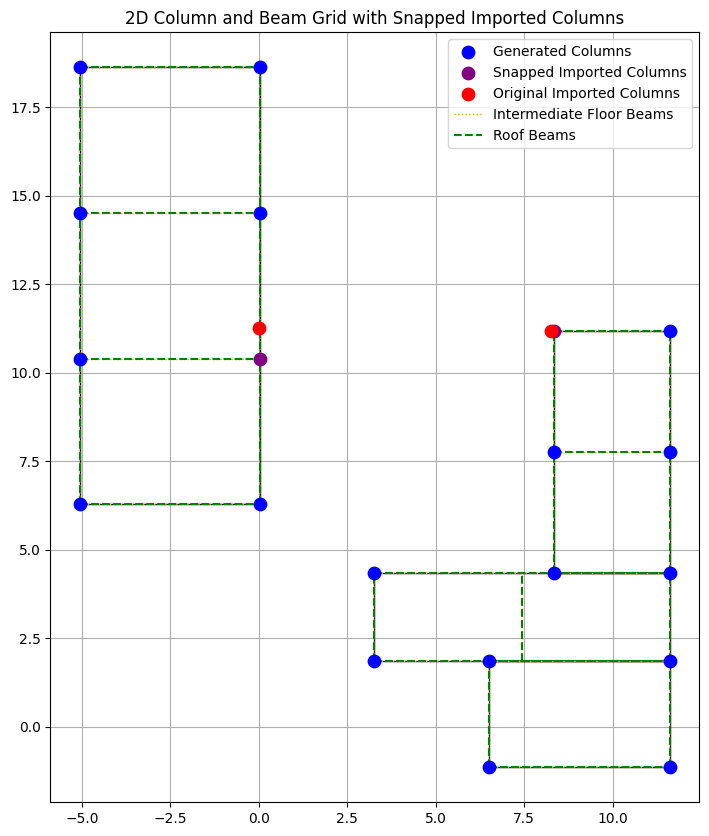


--- Analyzing Beams for Levitating Over Sloped Roof ---

--- Beam Segment Analysis ---
  2D Coords: (-5.05, 6.29) to (-5.05, 18.63)
  Associated Room WKT: POLYGON ((-5.052224159240723 18.633899688720703, 0...
  Floor Type: Intermediate (Floor 1)
  Beam Zs: Start=1.52, End=1.52
  Actual Architectural Zs: Start=3.02, End=3.02
  Is Levitating over Architectural Surface? NO

--- Beam Segment Analysis ---
  2D Coords: (-5.05, 6.29) to (-5.05, 18.63)
  Associated Room WKT: POLYGON ((-5.052224159240723 18.633899688720703, 0...
  Floor Type: Roof
  Beam Zs: Start=3.02, End=3.02
  Actual Architectural Zs: Start=3.02, End=3.02
  Is Levitating over Architectural Surface? NO

--- Beam Segment Analysis ---
  2D Coords: (0.04, 6.29) to (0.04, 18.63)
  Associated Room WKT: POLYGON ((-5.052224159240723 18.633899688720703, 0...
  Floor Type: Intermediate (Floor 1)
  Beam Zs: Start=1.52, End=1.52
  Actual Architectural Zs: Start=3.02, End=3.02
  Is Levitating over Architectural Surface? NO

--- Beam Se

Widget(value='<iframe src="http://localhost:61263/index.html?ui=P_0x2b9a20b2850_13&reconnect=auto" class="pyvi…

In [17]:
# DONT TOUCH!!!

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, LineString # LineString is used for the previous (now reverted) clipping logic, kept for other uses.
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
if model is None:
    raise RuntimeError(f"Could not read Rhino model from {rhino_path}. It might be corrupted or an invalid file.")

layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0
min_z_global = float('inf') # Initialize global min_z

wall_breps = []

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area)
        else:
            return None
    return None

room_brep_map = {}

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly)
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom})
            max_z = max(max_z, bbox.Max.Z)
            min_z_global = min(min_z_global, bbox.Min.Z) # Update global min_z
            room_brep_map[poly.wkt] = geom


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    # REVERTED: Removed the LineString.intersects() condition here to match original behavior
    for x in x_points:
        beams.append(((x, miny), (x, maxy), room_poly))   # Add room info
    for y in y_points:
        beams.append(((minx, y), (maxx, y), room_poly))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)


# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns: # Changed back to original logic to show all imported columns
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2), _ in beams:
    # Ensure beam is long enough for visualization - this was already in your code, keeping it.
    if np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2])) < 0.1:
        continue

    if num_floors > 1:
        for floor in range(1, num_floors):   # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                                     label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                                 label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data, search_radius=0.5):
    """
    Finds the maximum Z-coordinate (height) of a wall mesh vertex within a given
    search radius of the (x,y) query point.
    Falls back to bounding box Max.Z if no mesh vertex is found nearby,
    and then to global max_z.
    """
    max_height = 0.0
    query_point_2d = np.array([x, y])

    for wall in wall_data:
        brep = wall['brep']
        all_meshes = []
        for face in brep.Faces:
            try:
                m = face.GetMesh(rhino3dm.MeshType.Render)
                if m:
                    all_meshes.append(m)
            except Exception as e:
                continue

        for mesh in all_meshes:
            for i in range(len(mesh.Vertices)):
                v = mesh.Vertices[i]
                vx, vy, vz = v.X, v.Y, v.Z
                dist = np.linalg.norm(query_point_2d - np.array([vx, vy]))
                if dist < search_radius:
                    max_height = max(max_height, vz)

    # Fallback: if nothing found within radius, use bounding box max
    if max_height == 0.0:
        for wall in wall_data:
            poly = wall['polygon']
            # Check if point is within the polygon, then use its bbox max Z
            if Point(x, y).within(poly.buffer(search_radius)): # Use buffer for robustness
                return wall['bbox'].Max.Z
        return max_z # Return global max_z if no relevant wall found

    return max_height


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    # Use the global min_z for the column base, and wall_height for the top
    column_top_z = get_wall_height(x, y, wall_breps)
    column_height = column_top_z - min_z_global
    column_center_z = min_z_global + column_height / 2
    
    # Ensure column height is positive and reasonable
    if column_height > 0.1: # Small threshold to avoid tiny/negative cylinders (e.g., 10cm minimum height)
        cylinder = pv.Cylinder(center=(x, y, column_center_z), direction=(0, 0, 1),
                                 radius=0.1, height=column_height)
        plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04   # thinner than column radius 0.1

# Define a tolerance for detecting "levitating" beams
LEVITATING_TOLERANCE = 0.1 # 10 cm, tune as needed

print("\n--- Analyzing Beams for Levitating Over Sloped Roof ---")

for (x1, y1), (x2, y2), poly in beams:
    brep = room_brep_map.get(poly.wkt)
    if not brep:
        continue   # Skip if this room has no brep

    # Get the bounding box for the current room's BREP
    room_bbox = brep.GetBoundingBox()
    room_min_z = room_bbox.Min.Z
    room_max_z = room_bbox.Max.Z

    # Calculate floor height for intermediate floors based on the room's bounding box height
    floor_height_interval = (room_max_z - room_min_z) / num_floors


    for floor in range(1, num_floors + 1): # Iterate from 1 up to num_floors for structural floors
        z1_beam = None
        z2_beam = None
        floor_type = ""

        if floor == num_floors:
            # For the top floor, keep the sloped roof
            # REVERTED: Using local_wall_data as in original code
            local_wall_data = [{'polygon': poly, 'brep': brep, 'bbox': room_bbox}]
            z1_beam = get_wall_height(x1, y1, local_wall_data)
            z2_beam = get_wall_height(x2, y2, local_wall_data)
            floor_type = "Roof"
        else:
            # For intermediate floors, use the bounding box min Z and divide the total height
            # REMOVED: The `if floor == 0` check here, as the loop starts at 1, making it irrelevant.
            z1_beam = z2_beam = room_min_z + floor * floor_height_interval
            floor_type = f"Intermediate (Floor {floor})"

        # If z_beam values were calculated (i.e., not skipped by conditions like ground-level base beam)
        if z1_beam is not None and z2_beam is not None:
            # Get the actual architectural surface Z at these points from the *entire* building model
            # This is crucial for *comparison* to find levitating beams.
            actual_arch_z1 = get_wall_height(x1, y1, wall_breps) # Use global wall_breps for comparison
            actual_arch_z2 = get_wall_height(x2, y2, wall_breps) # Use global wall_breps for comparison

            # Determine if it's levitating
            # A beam is considered levitating if *both* its start and end points are significantly above the architectural surface
            is_levitating_at_p1 = (z1_beam > actual_arch_z1 + LEVITATING_TOLERANCE)
            is_levitating_at_p2 = (z2_beam > actual_arch_z2 + LEVITATING_TOLERANCE)
            
            is_overall_levitating = is_levitating_at_p1 and is_levitating_at_p2

            print(f"\n--- Beam Segment Analysis ---")
            print(f"  2D Coords: ({x1:.2f}, {y1:.2f}) to ({x2:.2f}, {y2:.2f})")
            print(f"  Associated Room WKT: {poly.wkt[:50]}...") # Print a truncated WKT for readability
            print(f"  Floor Type: {floor_type}")
            print(f"  Beam Zs: Start={z1_beam:.2f}, End={z2_beam:.2f}")
            print(f"  Actual Architectural Zs: Start={actual_arch_z1:.2f}, End={actual_arch_z2:.2f}")
            print(f"  Is Levitating over Architectural Surface? {'YES' if is_overall_levitating else 'NO'}")
            if is_overall_levitating:
                print(f"    (Beam Z - Arch Z Differences): Start={z1_beam - actual_arch_z1:.2f}, End={z2_beam - actual_arch_z2:.2f}")

            # Prepare beam for PyVista visualization (existing logic)
            start = np.array([x1, y1, z1_beam])
            end = np.array([x2, y2, z2_beam])

            direction = end - start
            length = np.linalg.norm(direction)
            if length < 1e-6: # Skip very short beams
                continue
            direction = direction / length
            center = (start + end) / 2

            beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

            # Determine color based on floor and levitating status
            if is_overall_levitating:
                plotter.add_mesh(beam, color='red', opacity=0.8, lighting=True, render_lines_as_tubes=True, line_width=10) # Make levitating beams very noticeable
            elif floor == num_floors:
                color = 'green' # Roof beams
            else: # Intermediate floor beams (and previously base beams, now handled by floor_idx in previous loop)
                color = 'orange'
            
            # Add to plotter only if not already added by levitating logic
            if not is_overall_levitating:
                 plotter.add_mesh(beam, color=color) # Only add if not marked red already


# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except Exception as e:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                    faces.append((4,) + idxs)
                elif len(f) == 3:
                    idxs = (f[0], f[1], f[2])
                    faces.append((3,) + idxs)
                else:
                    continue # Skip faces with unexpected number of vertices
            faces_flat = [i for face in faces for i in face]
            if pts and faces_flat:
                pv_mesh = pv.PolyData(pts, faces_flat)
                plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

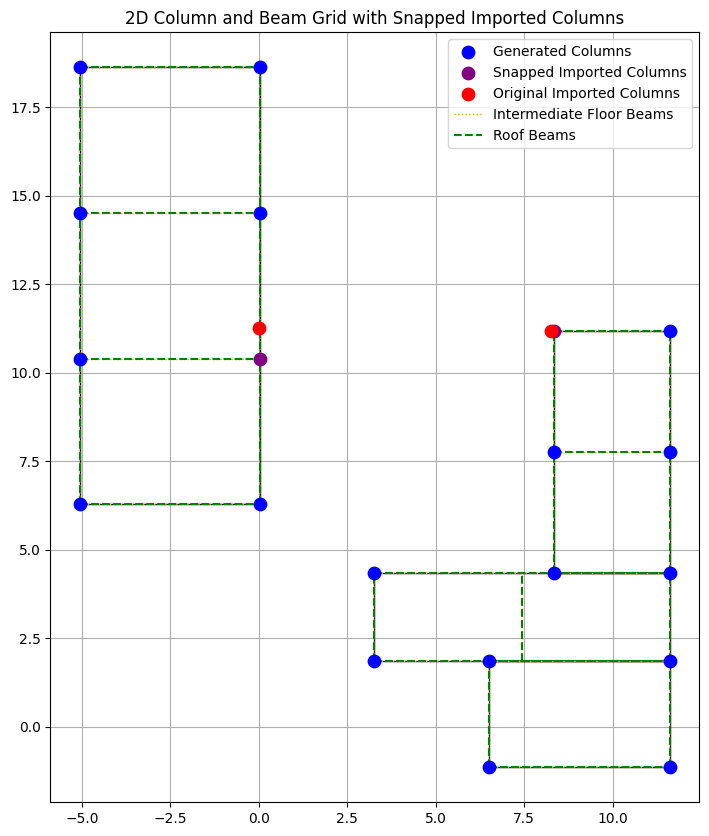


--- Analyzing Beams for Levitating Over Sloped Roof ---

--- Beam Segment Analysis ---
  2D Coords: (-5.05, 6.29) to (-5.05, 18.63)
  Associated Room WKT: POLYGON ((-5.052224159240723 18.633899688720703, 0...
  Floor Type: Intermediate (Floor 1)
  Beam Zs: Start=1.52, End=1.52
  Actual Architectural Zs: Start=3.02, End=3.02
  Is Levitating over Architectural Surface? NO

--- Beam Segment Analysis ---
  2D Coords: (-5.05, 6.29) to (-5.05, 18.63)
  Associated Room WKT: POLYGON ((-5.052224159240723 18.633899688720703, 0...
  Floor Type: Roof
  Beam Zs: Start=3.02, End=3.02
  Actual Architectural Zs: Start=3.02, End=3.02
  Is Levitating over Architectural Surface? NO

--- Beam Segment Analysis ---
  2D Coords: (0.04, 6.29) to (0.04, 18.63)
  Associated Room WKT: POLYGON ((-5.052224159240723 18.633899688720703, 0...
  Floor Type: Intermediate (Floor 1)
  Beam Zs: Start=1.52, End=1.52
  Actual Architectural Zs: Start=3.02, End=3.02
  Is Levitating over Architectural Surface? NO

--- Beam Se

Widget(value='<iframe src="http://localhost:61263/index.html?ui=P_0x2ba3fd94f50_14&reconnect=auto" class="pyvi…

In [18]:
# DONT TOUCH!!!

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm" #
if not os.path.exists(rhino_path): #
    raise FileNotFoundError(f"File not found: {rhino_path}") #

# Load model
model = rhino3dm.File3dm.Read(rhino_path) #
if model is None: #
    raise RuntimeError(f"Could not read Rhino model from {rhino_path}. It might be corrupted or an invalid file.") #

layers = {layer.Name.lower(): layer.Index for layer in model.Layers} #
if 'building' not in layers or ('column' not in layers and 'columns' not in layers): #
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.") #

column_layer = 'columns' if 'columns' in layers else 'column' #

# Extract building volume & height
building_volumes = [] #
imported_columns = [] #
max_z = 0.0 #
min_z_global = float('inf') # Initialize global min_z #

wall_breps = [] #

def brep_to_floor_polygon(brep):
    all_polygons = [] #

    for face in brep.Faces: #
        mesh = face.GetMesh(rhino3dm.MeshType.Render) #
        if not mesh: #
            continue #

        for i in range(len(mesh.Faces)): #
            f = mesh.Faces[i] #
            idxs = list(f) #

            # Handle triangle or quad
            if len(idxs) == 4: #
                idxs = idxs[:4] #
            elif len(idxs) == 3: #
                idxs = idxs[:3] #

            verts = [mesh.Vertices[j] for j in idxs] #
            points_2d = [(v.X, v.Y) for v in verts] #

            if len(points_2d) >= 3: #
                try: #
                    polygon = Polygon(points_2d) #
                    if polygon.is_valid and polygon.area > 0: #
                        all_polygons.append(polygon) #
                except: #
                    continue #

    if all_polygons: #
        union = unary_union(all_polygons) #
        if union.geom_type == 'Polygon': #
            return union #
        elif union.geom_type == 'MultiPolygon': #
            return max(union.geoms, key=lambda p: p.area) #
        else: #
            return None #
    return None #

room_brep_map = {} #

for obj in model.Objects: #
    layer_idx = obj.Attributes.LayerIndex #
    geom = obj.Geometry #

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep: #
        poly = brep_to_floor_polygon(geom) #
        if poly: #
            bbox = geom.GetBoundingBox() #
            building_volumes.append(poly) #
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom}) #
            max_z = max(max_z, bbox.Max.Z) #
            min_z_global = min(min_z_global, bbox.Min.Z) # Update global min_z #
            room_brep_map[poly.wkt] = geom #


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep: #
        bbox = geom.GetBoundingBox() #
        center_x = (bbox.Min.X + bbox.Max.X) / 2 #
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2 #
        imported_columns.append((center_x, center_y)) #

if not building_volumes: #
    raise RuntimeError("No valid building geometry found on the 'building' layer.") #

# Ask for number of floors
while True: #
    try: #
        num_floors = int(input("How many floors does the building have? (e.g., 2): ")) #
        if num_floors < 1: #
            raise ValueError #
        break #
    except ValueError: #
        print("Please enter a valid positive integer for the number of floors.") #

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1]) #

# Structural logic
MaxS = 6.0 #
MinS = 3.0 #

columns = [] #
corrected_columns = [] #
available_imported = imported_columns.copy() #
existing_columns = imported_columns.copy() #
beams = [] #

for room_poly, _ in detected_rooms: #
    minx, miny, maxx, maxy = room_poly.bounds #
    width, height = maxx - minx, maxy - miny #
    divisions_x = int(np.ceil(width / MaxS)) #
    divisions_y = int(np.ceil(height / MaxS)) #
    x_points = np.linspace(minx, maxx, divisions_x + 1) #
    y_points = np.linspace(miny, maxy, divisions_y + 1) #
    room_candidates = [(x, y) for x in x_points for y in y_points] #

    for col in room_candidates: #
        snap = False #
        for imp_col in available_imported: #
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS: #
                corrected_columns.append(col) #
                existing_columns.append(col) #
                available_imported.remove(imp_col) #
                snap = True #
                break #
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns): #
            columns.append(col) #
            existing_columns.append(col) #

    # REVERTED: Removed the LineString.intersects() condition here to match original behavior
    for x in x_points: #
        beams.append(((x, miny), (x, maxy), room_poly))   # Add room info #
    for y in y_points: #
        beams.append(((minx, y), (maxx, y), room_poly)) #

    for corner in list(room_poly.exterior.coords): #
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns): #
            columns.append(corner) #
            existing_columns.append(corner) #


# Combine all base columns
all_base_columns = columns + corrected_columns #

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10)) #

# Room outlines
for poly, _ in detected_rooms: #
    px, py = poly.exterior.xy #
    ax.plot(px, py, 'k-', linewidth=1) #

# Generated columns
if columns: #
    gx, gy = zip(*columns) #
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5) #

# Snapped imported columns
if corrected_columns: #
    cx, cy = zip(*corrected_columns) #
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7) #

# Original imported columns
if imported_columns: # Changed back to original logic to show all imported columns #
    ix, iy = zip(*imported_columns) #
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10) #

intermediate_label_added = False #
roof_label_added = False #

for (x1, y1), (x2, y2), _ in beams: #
    # Ensure beam is long enough for visualization - this was already in your code, keeping it.
    if np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2])) < 0.1: #
        continue #

    if num_floors > 1: #
        for floor in range(1, num_floors):   # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                                     label='Intermediate Floor Beams' if not intermediate_label_added else "") #
            intermediate_label_added = True #

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                                 label='Roof Beams' if not roof_label_added else "") #
    roof_label_added = True #

ax.set_aspect('equal', 'box') #
ax.legend() #
plt.title("2D Column and Beam Grid with Snapped Imported Columns") #
ax.grid(True) #
plt.show() #

def get_wall_height(x, y, wall_data, search_radius=0.5):
    """
    Finds the maximum Z-coordinate (height) of a wall mesh vertex within a given
    search radius of the (x,y) query point.
    Falls back to bounding box Max.Z if no mesh vertex is found nearby,
    and then to global max_z.
    """
    max_height = 0.0 #
    query_point_2d = np.array([x, y]) #

    for wall in wall_data: #
        brep = wall['brep'] #
        all_meshes = [] #
        for face in brep.Faces: #
            try: #
                m = face.GetMesh(rhino3dm.MeshType.Render) #
                if m: #
                    all_meshes.append(m) #
            except Exception as e: #
                continue #

        for mesh in all_meshes: #
            for i in range(len(mesh.Vertices)): #
                v = mesh.Vertices[i] #
                vx, vy, vz = v.X, v.Y, v.Z #
                dist = np.linalg.norm(query_point_2d - np.array([vx, vy])) #
                if dist < search_radius: #
                    max_height = max(max_height, vz) #

    # Fallback: if nothing found within radius, use bounding box max
    if max_height == 0.0: #
        for wall in wall_data: #
            poly = wall['polygon'] #
            # Check if point is within the polygon, then use its bbox max Z
            if Point(x, y).within(poly.buffer(search_radius)): # Use buffer for robustness #
                return wall['bbox'].Max.Z #
        return max_z # Return global max_z if no relevant wall found #

    return max_height #


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System") #

# Columns as vertical cylinders
for x, y in all_base_columns: #
    # Use the global min_z for the column base, and wall_height for the top
    column_top_z = get_wall_height(x, y, wall_breps) #
    column_height = column_top_z - min_z_global #
    column_center_z = min_z_global + column_height / 2 #
    
    # Ensure column height is positive and reasonable
    if column_height > 0.1: # Small threshold to avoid tiny/negative cylinders (e.g., 10cm minimum height) #
        cylinder = pv.Cylinder(center=(x, y, column_center_z), direction=(0, 0, 1),
                                 radius=0.1, height=column_height) #
        plotter.add_mesh(cylinder, color='blue') #

# Beams as thinner cylinders
beam_radius = 0.04   # thinner than column radius 0.1 #

# Define a tolerance for detecting "levitating" beams
LEVITATING_TOLERANCE = 0.1 # 10 cm, tune as needed #

print("\n--- Analyzing Beams for Levitating Over Sloped Roof ---") #

for (x1, y1), (x2, y2), poly in beams: #
    brep = room_brep_map.get(poly.wkt) #
    if not brep: #
        continue   # Skip if this room has no brep #

    # Get the bounding box for the current room's BREP
    room_bbox = brep.GetBoundingBox() #
    room_min_z = room_bbox.Min.Z #
    room_max_z = room_bbox.Max.Z #

    # Calculate floor height for intermediate floors based on the room's bounding box height
    floor_height_interval = (room_max_z - room_min_z) / num_floors #


    for floor in range(1, num_floors + 1): # Iterate from 1 up to num_floors for structural floors #
        z1_beam = None #
        z2_beam = None #
        floor_type = "" #

        if floor == num_floors: #
            # For the top floor, keep the sloped roof
            # REVERTED: Using local_wall_data as in original code
            local_wall_data = [{'polygon': poly, 'brep': brep, 'bbox': room_bbox}] #
            z1_beam = get_wall_height(x1, y1, local_wall_data) #
            z2_beam = get_wall_height(x2, y2, local_wall_data) #
            floor_type = "Roof" #
        else: #
            # For intermediate floors, use the bounding box min Z and divide the total height
            # REMOVED: The `if floor == 0` check here, as the loop starts at 1, making it irrelevant.
            z1_beam = z2_beam = room_min_z + floor * floor_height_interval #
            floor_type = f"Intermediate (Floor {floor})" #

        # If z_beam values were calculated (i.e., not skipped by conditions like ground-level base beam)
        if z1_beam is not None and z2_beam is not None: #
            # Get the actual architectural surface Z at these points from the *entire* building model
            # This is crucial for *comparison* to find levitating beams.
            actual_arch_z1 = get_wall_height(x1, y1, wall_breps) # Use global wall_breps for comparison #
            actual_arch_z2 = get_wall_height(x2, y2, wall_breps) # Use global wall_breps for comparison #

            # Determine if it's levitating
            # A beam is considered levitating if *both* its start and end points are significantly above the architectural surface
            is_levitating_at_p1 = (z1_beam > actual_arch_z1 + LEVITATING_TOLERANCE) #
            is_levitating_at_p2 = (z2_beam > actual_arch_z2 + LEVITATING_TOLERANCE) #
            
            is_overall_levitating = is_levitating_at_p1 and is_levitating_at_p2 #

            print(f"\n--- Beam Segment Analysis ---") #
            print(f"  2D Coords: ({x1:.2f}, {y1:.2f}) to ({x2:.2f}, {y2:.2f})") #
            print(f"  Associated Room WKT: {poly.wkt[:50]}...") # Print a truncated WKT for readability #
            print(f"  Floor Type: {floor_type}") #
            print(f"  Beam Zs: Start={z1_beam:.2f}, End={z2_beam:.2f}") #
            print(f"  Actual Architectural Zs: Start={actual_arch_z1:.2f}, End={actual_arch_z2:.2f}") #
            print(f"  Is Levitating over Architectural Surface? {'YES' if is_overall_levitating else 'NO'}") #
            if is_overall_levitating: #
                print(f"    (Beam Z - Arch Z Differences): Start={z1_beam - actual_arch_z1:.2f}, End={z2_beam - actual_arch_z2:.2f}") #

            # Prepare beam for PyVista visualization (existing logic)
            start = np.array([x1, y1, z1_beam]) #
            end = np.array([x2, y2, z2_beam]) #

            direction = end - start #
            length = np.linalg.norm(direction) #
            if length < 1e-6: # Skip very short beams #
                continue #
            direction = direction / length #
            center = (start + end) / 2 #

            beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length) #

            # Determine color based on floor and levitating status
            if is_overall_levitating: #
                plotter.add_mesh(beam, color='red', opacity=0.8, lighting=True, render_lines_as_tubes=True, line_width=10) # Make levitating beams very noticeable #
            elif floor == num_floors: #
                color = 'green' # Roof beams #
            else: # Intermediate floor beams (and previously base beams, now handled by floor_idx in previous loop)
                color = 'orange' #
            
            # Add to plotter only if not already added by levitating logic
            if not is_overall_levitating: #
                 plotter.add_mesh(beam, color=color) # Only add if not marked red already #


# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any): #
    meshes = [] #
    for face in brep.Faces: #
        try: #
            m = face.GetMesh(mesh_type) #
            if m: meshes.append(m) #
        except Exception as e: #
            continue #
    return meshes #

for obj in model.Objects: #
    geom = obj.Geometry #
    layer_idx = obj.Attributes.LayerIndex #
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep): #
        meshes = mesh_brep(geom) #
        for mesh in meshes: #
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices] #
            faces = [] #
            for f in mesh.Faces: #
                if len(f) == 4: #
                    idxs = (f[0], f[1], f[2], f[3]) #
                    faces.append((4,) + idxs) #
                elif len(f) == 3: #
                    idxs = (f[0], f[1], f[2]) #
                    faces.append((3,) + idxs) #
                else: #
                    continue # Skip faces with unexpected number of vertices #
            faces_flat = [i for face in faces for i in face] #
            if pts and faces_flat: #
                pv_mesh = pv.PolyData(pts, faces_flat) #
                plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3) #

# Set up the camera and show
plotter.show_grid() #
plotter.show() #